In [ ]:
! sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended --fix-missing

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
You might want to run 'apt --fix-broken install' to correct these.
The following packages have unmet dependencies:
 dvipng : Depends: ghostscript but it is not going to be installed
 dvisvgm : Depends: libgs9 (>= 8.61.dfsg.1) but it is not going to be installed
E: Unmet dependencies. Try 'apt --fix-broken install' with no packages (or specify a solution).


In [ ]:
! pip install jax jaxlib --upgrade --quiet
! pip install neural-tangents --quiet

DESCRIPTION OF NOTEBOOK:

In [ ]:
#@title Imports
import os

# setup drive
from google.colab import drive
drive.mount('/content/drive')
folder_path = 'drive/MyDrive/MACHINELEARNING/Project/NTK/Experiments'

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.func import vmap, jacrev, functional_call

from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import datasets
import torchvision
import torchvision.transforms as transforms
from PIL import Image

from jax import random
import jax
from neural_tangents import stax
import neural_tangents as nt



import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import scienceplots
import numpy as np
from numpy import linalg as LA
import math
# plt.style.use('ggplot')
# plt.style.use('science')
import random

import cv2
import time
import urllib
import pickle
import itertools
from urllib.request import urlopen

from tqdm.notebook import tqdm

import matplotlib.animation as animation

from IPython.display import HTML
from base64 import b64encode

torch.manual_seed(3)
np.random.seed(3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Utils

# get list of all layers in order, https://stackoverflow.com/a/69544742
def flatten_model(modules):
    def flatten_list(_2d_list):
        flat_list = []
        # Iterate through the outer list
        for element in _2d_list:
            if type(element) is list:
                # If the element is of type list, iterate through the sublist
                for item in element:
                    flat_list.append(item)
            else:
                flat_list.append(element)
        return flat_list

    ret = []
    try:
        for _, n in modules:
            ret.append(flatten_model(n))
    except:
        try:
            if str(modules._modules.items()) == "odict_items([])":
                ret.append(modules)
            else:
                for _, n in modules._modules.items():
                    ret.append(flatten_model(n))
        except:
            ret.append(modules)
    return flatten_list(ret)

def apply_function(f, x, n):
    """Apply function f to x, n times."""
    for _ in range(n):
        x = f(x)
    return x


def compute_partial_products(nums):
    n = len(nums)
    # Result list with the same number of elements, initially empty
    result = [1] * n
    # Temporary variable to store the cumulative product
    product = 1
    # Traverse from end to start
    for i in range(n-1, -1, -1):
        # Update the product to include the current element
        product *= nums[i]
        # Store the cumulative product in the result
        result[i] = product
    return result

def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [ ]:
# Only work for MLP when we use normalized data and only same activation function. The variable name comes from Arora ("On exact computations ...") paper.
class MLP_ntk(nn.Module):
  def __init__(self):
    super(MLP_ntk, self).__init__()

  # works in normalized data settings. At first layer, rho = x^\top y
  def covar(self, rho):
    pass
  def dot_covar(self, rho):
    pass

  # compute the limit ntk of MLP.
  def ntk(self, x, y):
    modules = self._modules
    # print("modules:", modules)
    all_layers_list = list(modules)
    # print("all_layers_list:", all_layers_list)
    n_layers = len(all_layers_list)
    # print("n_layers:", n_layers)

    # data is normalized, we can implement it easily. Without round, we can get 1.000000029 value which can cause an error
    rho = torch.round(torch.dot(x, y), decimals = 4).item()
    # print("rho: ", rho)
    # compute all \Sigma_h by looking at \Lambda_h when h between 0 and L+1, where L is the number of layer.
    sigmas = [apply_function(self.covar, rho, i) for i in range(n_layers+1)]
    # print("sigmas: ",sigmas)
    # compute all \dot\Sigma_h, we dont need the first value of var "sigmas", so it's shifted (sigmas[i+1]).
    dot_sigmas = [self.dot_covar(sigmas[i+1]) for i in range(n_layers)]
    # print("dot_sigmas: ",dot_sigmas)

    partial_product_dotSigmas = compute_partial_products(dot_sigmas)
    # compute limit ntk using arora formula.
    ntk_limit = np.sum([sigmas[i] * partial_product_dotSigmas[i] for i in range(n_layers)])

    return ntk_limit

In [ ]:
class MLP_relu(MLP_ntk):
  def __init__(self):
    # DONT PUT ACTIVATIONS FUNCTION IN INIT, because it will be put into self._modules, we just want layers in self._modules and not the activations.
    super(MLP_relu, self).__init__()
    self.layer1 = nn.Linear(1, 10, bias = False)
    # self.layer2 = nn.Linear(5, 10, bias = False)
    self.layerf = nn.Linear(10,1, bias = False)
  def forward(self, x):
    x = F.ReLU(self.layer1(x))
    # x = F.ReLU(self.layer2(x))
    x = self.layerf(x)

    return x

  def covar(self, rho):
    return (np.sqrt(1-rho**2) + rho * np.arcsin(rho))/np.pi + rho/2

  def dot_covar(self, rho):
    return np.arcsin(rho)/np.pi + 1/2

In [ ]:
# Greg Yang Notations

# Only work for MLP when we use normalized data and only same activation function. The variable name comes from Arora ("On exact computations ...") paper.
class MLP_ntk(nn.Module):
  def __init__(self):
    super(MLP_ntk, self).__init__()

    # instantiate kernel values
    self.Kxx = 0
    self.Kyy = 0
    self.Kxy = 0

  # works in normalized data settings. At first layer, rho = x^\top y
  def V_func(self, rho):
    pass
  def dot_V_func(self, rho):
    pass

  # compute the limit ntk of MLP.
  def ntk(self, x, y):
    modules = self._modules
    # print("modules:", modules)
    all_layers_list = list(modules)
    # print("all_layers_list:", all_layers_list)
    # num of layer and also the final layer.
    # FLAG ERROR: -1
    n_layers = len(all_layers_list)
    # print("n_layers:", n_layers)

    # data is normalized, we can implement it easily. Without round, we can get 1.000000029 value which can cause an error
    self.Kxy = torch.dot(x, y).item()
    self.Kxx = torch.linalg.vector_norm(x).item()**2
    self.Kyy = torch.linalg.vector_norm(y).item()**2
    # print(self.Kxy, self.Kxx, self.Kyy)

    V_list = [torch.dot(x, y).item()]
    dot_V_list = []

    for i in range(1, n_layers+1):
      # FLAG : no round, seuil sur calcul V_func. c>1 => 0
      c = self.Kxy / (np.sqrt(self.Kxx * self.Kyy))
      # print(i)
      # see NTK formula Arora to understand the conditions. It just the translation of the formula.
      if i < n_layers:
        V_list.append(self.V_func(c = c, kxx = self.Kxx, kyy = self.Kyy))
        dot_V_list.append(self.dot_V_func(c = c))
      else:
        dot_V_list.append(self.dot_V_func(c = c))

      # compute new kernel value.
      self.Kxy = V_list[-1]
      # here c = 1.
      self.Kxx = self.V_func(c = 1., kxx = self.Kxx, kyy = self.Kxx)
      self.Kyy = self.V_func(c = 1., kxx = self.Kyy, kyy = self.Kyy)
      # print(self.Kxy, self.Kxx, self.Kyy)

    # print(V_list, dot_V_list)


    partial_product_dotV = compute_partial_products(dot_V_list)
    # compute limit ntk using Arora formula.
    ntk_limit = np.sum([V_list[i] * partial_product_dotV[i] for i in range(n_layers)])

    return ntk_limit

class MLP_relu(MLP_ntk):
  def __init__(self):
    # DONT PUT ACTIVATIONS FUNCTION IN INIT, because it will be put into self._modules, we just want layers in self._modules and not the activations.
    super(MLP_relu, self).__init__()
    self.layer1 = nn.Linear(1, 10, bias = False)
    # self.layer2 = nn.Linear(5, 10, bias = False)
    self.layerf = nn.Linear(10,1, bias = False)
  def forward(self, x):
    x = F.ReLU(self.layer1(x))
    # x = F.ReLU(self.layer2(x))
    x = self.layerf(x)

    return x

  # SEUIL.
  def V_func(self, c, kxx, kyy):
    c = np.clip(c, a_min = -1.0, a_max = 1.0)
    return (1/(2*np.pi)) * (np.sqrt(1-c**2)+(np.pi-np.arccos(c))*c)*np.sqrt(kxx * kyy)

  def dot_V_func(self, c):
    c = np.clip(c, a_min = -1.0, a_max = 1.0)
    return (1/(2*np.pi)) * (np.pi - np.arccos(c))

In [ ]:
model = MLP_relu()

In [ ]:
x, y = torch.randn(5), torch.randn(5)

In [ ]:
model.ntk(x,y)

1
2.363613328671069 5.748373469294421 2.799872582542122
2
2.363613328671069 2.8741867346472105 1.399936291271061
[3.770480155944824, 2.363613328671069] [0.3278730459302258, 0.35043613389166345]


1.2615182672311722

## NTK and regression

In [ ]:
model = MLP_relu()

In [ ]:
n_point = 50
X_train = torch.linspace(-1, 1, n_point)
Y_true = X_train + torch.sin(10*X_train)
delta = 5
Y_noise = Y_true + torch.randn(n_point)/delta

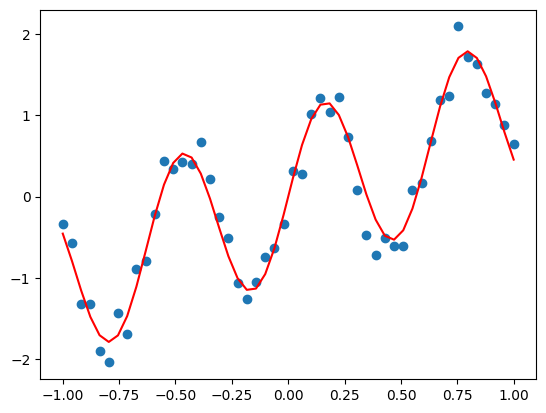

In [ ]:
plt.scatter(X_train.numpy(), Y_noise.numpy())
plt.plot(X_train.numpy(), Y_true.numpy(), color = "red")
plt.show()

In [ ]:
kernel_matrix = torch.zeros((n_point, n_point))
X_train_normalized = X_train / torch.abs(X_train)
# naive implementation
for i in range(n_point):
  for j in range(n_point):
    kernel_matrix[i, j] = model.ntk(X_train_normalized[i, None], X_train_normalized[j, None])

In [ ]:
kernel_matrix_inverted = torch.linalg.pinv(kernel_matrix)
n_pred = 100
X_test = torch.linspace(-10, 10, n_pred)
X_test_normalized = X_test / torch.abs(X_test)

kernel_matrix_test = torch.zeros((n_pred, n_point))

for i in range(n_pred):
  for j in range(n_point):
    kernel_matrix_test[i, j] = model.ntk(X_test_normalized[i, None], X_train_normalized[j, None])

predictions = kernel_matrix_test @ kernel_matrix_inverted @ Y_noise

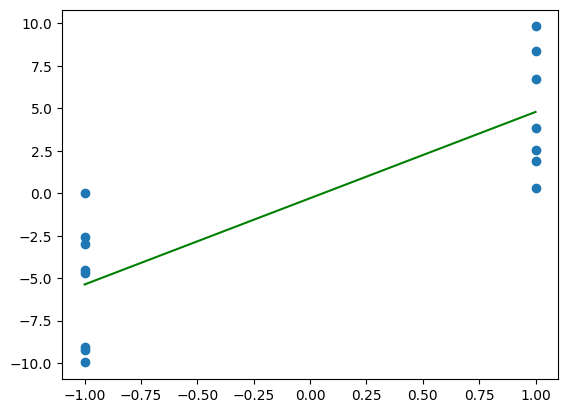

In [ ]:
plt.scatter(X_train_normalized.numpy(), Y_noise.numpy())
# plt.plot(X_train_normalized.numpy(), Y_true.numpy(), color = "red")
plt.plot(X_test_normalized.numpy(), predictions.numpy(), color = "green")
plt.show()

In [ ]:
kernel_matrix_inverted @ Y_noise

tensor([-0.2954, -0.2954, -0.2954, -0.2954, -0.2954, -0.2954, -0.2954, -0.2954,
         0.2883,  0.2883,  0.2883,  0.2883,  0.2883,  0.2883,  0.2883])

In [ ]:
from jax import random
import jax
from neural_tangents import stax

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(512), stax.Relu(),
    stax.Dense(1)
)

# key1, key2 = random.split(random.PRNGKey(1))
# x1 = random.normal(key1, (10, 100))
# x2 = random.normal(key2, (20, 100))

# kernel = kernel_fn(X_train_normalized[:, None].numpy(), X_train_normalized[:, None].numpy(), 'ntk')
kernel = kernel_fn(X_train[:, None].numpy(), X_train[:, None].numpy(), 'ntk')
# kernel = kernel_fn(x1, x1, 'ntk')

In [ ]:
# kernel_inverse = jax.numpy.linalg.inv(kernel+0.001*jax.numpy.identity(kernel.shape[0]))
kernel_inverse = jax.numpy.linalg.pinv(kernel)
n_pred = 100
X_test = torch.linspace(-1, 1, n_pred)
# X_test = X_train
# X_test = torch.cat([torch.linspace(-10, 10, n_pred), X_train])
# X_test_normalized = X_test / torch.abs(X_test)

# kernel_test = kernel_fn(X_test_normalized[:, None].numpy(), X_train_normalized[:, None].numpy(), 'ntk')
kernel_test = kernel_fn(X_test[:, None].numpy(), X_train[:, None].numpy(), 'ntk')
# kernel_test = kernel_fn(X_train[:, None].numpy(), X_train[:, None].numpy(), 'ntk')

# predictions = (kernel_test+0.1*jax.numpy.identity(kernel.shape[0])) @ kernel_inverse @ Y_noise.numpy()
predictions = (kernel_test) @ kernel_inverse @ Y_noise.numpy()

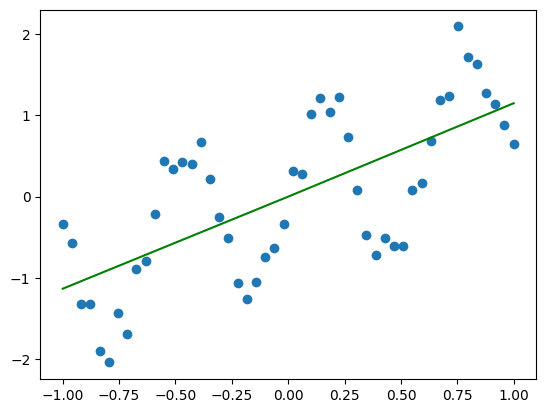

In [ ]:
plt.scatter(X_train, Y_noise)
# plt.plot(X_test.numpy(), Y_true.numpy(), color = "red")
plt.plot(X_test, predictions, color = "green")
plt.show()

## NTK and classification in dim 2

In [ ]:
n_point = 50
data_dim = 2
X_train = torch.randn((n_point, 2), dtype = torch.float64)
# Y_train = torch.randint(0, 2, (n_point,), dtype = torch.float32)
Y_train = torch.sum(X_train, dim = 1) + 0.1*torch.randn((n_point,),dtype = torch.float64)

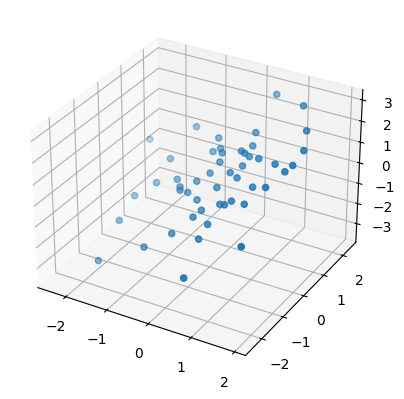

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train.numpy())
plt.show()

In [ ]:
init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512), stax.Relu(),
    stax.Dense(1)
)

# key1, key2 = random.split(random.PRNGKey(1))
# x1 = random.normal(key1, (10, 100))
# x2 = random.normal(key2, (20, 100))

# kernel = kernel_fn(X_train_normalized[:, None].numpy(), X_train_normalized[:, None].numpy(), 'ntk')
kernel = kernel_fn(X_train.numpy(), X_train.numpy(), 'ntk')
# kernel = kernel_fn(x1, x1, 'ntk')

In [ ]:
# kernel_inverse = jax.numpy.linalg.inv(kernel+0.001*jax.numpy.identity(kernel.shape[0]))
kernel_inverse = jax.numpy.linalg.inv(kernel)
# n_pred = 100
X_test = torch.randn((100, 2))
# X_test = X_train
# X_test = torch.cat([torch.linspace(-10, 10, n_pred), X_train])
# X_test_normalized = X_test / torch.abs(X_test)

# kernel_test = kernel_fn(X_test_normalized[:, None].numpy(), X_train_normalized[:, None].numpy(), 'ntk')
kernel_test = kernel_fn(X_test.numpy(), X_train.numpy(), 'ntk')
# kernel_test = kernel_fn(X_train[:, None].numpy(), X_train[:, None].numpy(), 'ntk')

# predictions = (kernel_test+0.1*jax.numpy.identity(kernel.shape[0])) @ kernel_inverse @ Y_noise.numpy()
predictions = (kernel_test) @ kernel_inverse @ Y_train.numpy()

In [ ]:
jax.numpy.abs(predictions - torch.sum(X_test, dim = 1).numpy())

Array([3.75614166e-02, 5.40338159e-02, 2.80754566e-02, 6.96825981e-03,
       1.97823048e-02, 5.05399704e-02, 6.24583960e-02, 5.51733971e-02,
       5.14808297e-02, 6.41512871e-03, 1.53037086e-02, 6.93494081e-03,
       2.72795141e-01, 4.64585200e-02, 1.44885778e-01, 1.88688517e-01,
       3.77411842e-02, 1.75002098e-01, 5.32517433e-02, 4.59820032e-04,
       5.27100563e-02, 1.08310699e-01, 8.24306011e-02, 1.08595192e-02,
       1.22990251e-01, 7.68327713e-03, 4.52646017e-02, 3.16611528e-02,
       8.89586210e-02, 8.98087025e-03, 3.86726856e-03, 5.72119951e-02,
       2.04294920e-03, 4.14101481e-02, 4.54683304e-02, 3.44529152e-02,
       1.83763206e-02, 1.28849506e-01, 3.40884089e-01, 1.32082701e-01,
       6.62032366e-02, 8.51720721e-02, 1.79041028e-01, 7.31676817e-02,
       1.37610465e-01, 1.85552180e-01, 1.08969212e-02, 4.51324582e-01,
       1.27725720e-01, 8.26489925e-03, 3.06924209e-02, 9.75384712e-02,
       2.06015110e-02, 1.53485835e-02, 3.73115540e-02, 6.16891384e-02,
      

[]

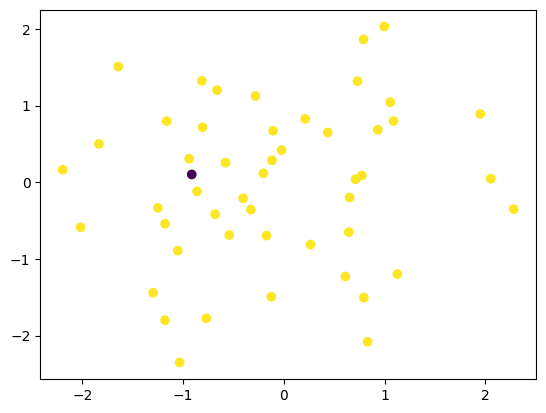

In [ ]:
cmap_wrong = jax.numpy.abs(predictions - Y_train.numpy()) >= 0.1
plt.scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], c = cmap_wrong)
plt.plot()

In [ ]:
jax.numpy.abs(predictions - Y_train.numpy())

Array([5.72174683e+01, 1.09329116e+00, 6.32604790e+00, 1.24876871e+01,
       2.73793077e+00, 2.72569954e-01, 1.06087265e+01, 5.35073547e+01,
       3.37669492e+00, 1.76293011e+01, 2.72571106e+01, 2.70778275e+00,
       5.78762913e+00, 1.89863348e+00, 9.79804277e-01, 1.27004471e+01,
       1.98289833e+01, 1.83603039e+01, 2.36491394e+00, 1.16239853e+01,
       1.02414351e+01, 3.61197948e-01, 5.48174858e-01, 1.13284149e+01,
       1.25341082e+00, 1.75199795e+00, 7.18340635e-01, 3.11275482e+00,
       2.43596630e+01, 4.43895340e-01, 3.08637094e+00, 9.47024155e+00,
       2.56742477e-01, 1.44134502e+01, 2.21190763e+00, 3.54536629e+00,
       5.22306442e+00, 1.40901542e+00, 4.71807837e-01, 1.77994366e+01,
       1.58053207e+00, 3.21962357e+00, 2.01155434e+01, 2.34712124e+00,
       5.84868383e+00, 3.98714542e-02, 2.59129095e+00, 4.37894726e+00,
       6.79970789e+00, 8.87413502e+00], dtype=float32)

In [ ]:
kernel

Array([[ 2.0500877e+00, -2.4049567e-02,  7.8611910e-01, ...,
         1.8604812e-01,  1.4814064e-01, -9.4826654e-02],
       [-2.4049567e-02,  1.1636879e-01,  8.1324577e-03, ...,
         2.0190610e-01, -1.8921290e-03,  1.4525802e-01],
       [ 7.8611910e-01,  8.1324577e-03,  9.4314188e-01, ...,
         8.2670838e-01, -3.0414756e-02, -3.3849534e-03],
       ...,
       [ 1.8604812e-01,  2.0190610e-01,  8.2670838e-01, ...,
         1.8071865e+00, -2.8649981e-03, -9.9898785e-02],
       [ 1.4814064e-01, -1.8921290e-03, -3.0414756e-02, ...,
        -2.8649981e-03,  2.3199952e-01,  3.7021869e-01],
       [-9.4826654e-02,  1.4525802e-01, -3.3849534e-03, ...,
        -9.9898785e-02,  3.7021869e-01,  1.4449826e+00]], dtype=float32)

In [ ]:
class MLP_relu(MLP_ntk):
  def __init__(self):
    # DONT PUT ACTIVATIONS FUNCTION IN INIT, because it will be put into self._modules, we just want layers in self._modules and not the activations.
    super(MLP_relu, self).__init__()
    self.layer1 = nn.Linear(2, 10, bias = False)
    # self.layer2 = nn.Linear(5, 10, bias = False)
    self.layerf = nn.Linear(10,1, bias = False)
  def forward(self, x):
    x = F.ReLU(self.layer1(x))
    # x = F.ReLU(self.layer2(x))
    x = self.layerf(x)

    return x

  def V_func(self, c, kxx, kyy):
    return (1/(2*np.pi)) * (np.sqrt(1-c**2)+(np.pi-np.arccos(c))*c)*np.sqrt(kxx * kyy)

  def dot_V_func(self, c):
    return (1/(2*np.pi)) * (np.pi - np.arccos(c))

In [ ]:
model = MLP_relu()

In [ ]:
kernel_matrix = torch.zeros((n_point, n_point), dtype = torch.float32)
X_train_normalized = X_train / torch.linalg.vector_norm(X_train, dim = 1, keepdim=True)
# naive implementation
for i in range(n_point):
  for j in range(n_point):
    kernel_matrix[i, j] = model.ntk(X_train_normalized[i], X_train_normalized[j])

In [ ]:
# Greg Yang version
kernel_matrix = torch.zeros((n_point, n_point), dtype = torch.float64)
# naive implementation
for i in range(n_point):
  for j in range(n_point):
    kernel_matrix[i, j] = model.ntk(X_train[i], X_train[j])

In [ ]:
kernel_matrix

tensor([[ 0.1543,  0.0114,  0.2310,  ...,  0.1752,  0.0677,  0.0414],
        [ 0.0114,  0.5855, -0.0324,  ...,  0.0943,  0.3639,  0.1231],
        [ 0.2310, -0.0324,  1.7864,  ...,  0.1543, -0.0154,  0.0048],
        ...,
        [ 0.1752,  0.0943,  0.1543,  ...,  0.3890,  0.2320,  0.1239],
        [ 0.0677,  0.3639, -0.0154,  ...,  0.2320,  0.5248,  0.1990],
        [ 0.0414,  0.1231,  0.0048,  ...,  0.1239,  0.1990,  0.0945]],
       dtype=torch.float64)

In [ ]:
kernel

Array([[ 0.15434743,  0.02002506,  0.30777353, ...,  0.20391703,
         0.10119499,  0.05809608],
       [ 0.02002506,  0.5854987 , -0.06422872, ...,  0.14478354,
         0.43559596,  0.15725948],
       [ 0.30777353, -0.06422872,  1.7864133 , ...,  0.23897302,
        -0.02888821,  0.00872771],
       ...,
       [ 0.20391703,  0.14478354,  0.23897302, ...,  0.3890036 ,
         0.2977805 ,  0.14907551],
       [ 0.10119499,  0.43559596, -0.02888821, ...,  0.2977805 ,
         0.52477443,  0.21186376],
       [ 0.05809608,  0.15725948,  0.00872771, ...,  0.14907551,
         0.21186376,  0.09452554]], dtype=float32)

In [ ]:
diff = np.abs(kernel_matrix.numpy() - kernel)
print(np.min(diff), np.max(diff))

0.0 0.53256464


In [ ]:
# kernel_inverse = jax.numpy.linalg.inv(kernel+0.001*jax.numpy.identity(kernel.shape[0]))
kernel_inverse = np.linalg.inv(kernel_matrix.numpy())
n_pred = 50
# X_test = torch.linspace(-1, 1, n_pred)
X_test = X_train
# X_test = torch.cat([torch.linspace(-10, 10, n_pred), X_train])
# X_test_normalized = X_test / torch.abs(X_test)

kernel_test = np.zeros((n_pred, n_pred))
for i in range(n_pred):
  for j in range(n_point):
    kernel_test[i, j] = model.ntk(X_train_normalized[i], X_train_normalized[j])

# predictions = (kernel_test+0.1*jax.numpy.identity(kernel.shape[0])) @ kernel_inverse @ Y_noise.numpy()
predictions = kernel_test @ kernel_inverse @ Y_train.numpy()

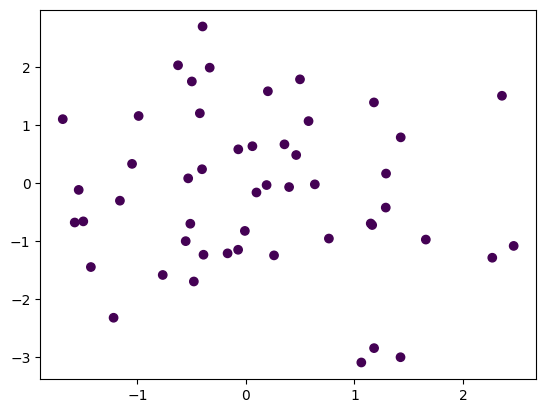

In [ ]:
cmap_wrong = jax.numpy.abs(predictions - Y_train.numpy()) >= 0.5
plt.scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], c = cmap_wrong)
plt.plot()
plt.show()

In [ ]:
jax.numpy.abs(predictions - Y_train.numpy())

Array([2.8483846e-04, 1.1555494e-03, 6.9069024e-04, 5.2683131e-04,
       5.2634749e-04, 1.6001549e-04, 3.8469749e-04, 1.0936938e-03,
       1.5543323e-03, 1.9627354e-04, 1.0148012e-03, 1.9171409e-03,
       6.8807683e-05, 2.1305519e-05, 2.4345172e-04, 1.5310555e-03,
       1.7202463e-03, 6.8439997e-04, 9.8507223e-04, 4.7574262e-04,
       4.4378641e-04, 2.7329294e-04, 1.3332289e-03, 4.4310043e-04,
       8.6496386e-04, 4.1504196e-04, 3.2221392e-04, 1.9071928e-04,
       1.7733579e-03, 1.9886051e-04, 6.3773862e-04, 3.5133413e-05,
       2.5649703e-04, 9.5980638e-04, 8.0171776e-05, 1.0573805e-04,
       2.6423339e-04, 4.7322022e-04, 2.8187205e-04, 2.3727792e-03,
       6.0332270e-04, 6.7292486e-04, 6.9957337e-04, 5.7820423e-04,
       6.6087738e-04, 8.2191161e-04, 1.0531351e-03, 1.8573774e-04,
       5.0991302e-04, 1.2819516e-03], dtype=float32)

## PyTorch to JAX

In [ ]:
convertion_dict = {"Linear": getattr(stax, 'Dense'), "ReLU": getattr(stax, 'Relu')}

def torchSeq_to_staxSeq(torchSeqModel):
  torch_layers_dict = torchSeqModel._modules
  stax_list = []
  for i in range(len(torchSeqModel)):
    torch_layer = torch_layers_dict[str(i)]
    torch_layer_str = type(torch_layer).__name__
    # TODO: split dict into type, meaning one dict for layers, one dict for activations functions.
    if torch_layer_str == "ReLU":
      stax_list.append(convertion_dict[torch_layer_str]())
    else:
      stax_list.append(convertion_dict[torch_layer_str](torch_layer.out_features))

  # print(len(stax_list))
  init_fn, apply_fn, kernel_fn = stax.serial(*stax_list)
  return init_fn, apply_fn, kernel_fn


In [ ]:
#@title sanity check kernel_fn (not init_fn and apply_fn)
sequential_net = nn.Sequential(nn.Linear(2,10),
                                    nn.ReLU(),
                               nn.Linear(10,50),
                               nn.ReLU(),
                               nn.Linear(50,1))

init_fn, apply_fn, kernel_fn = torchSeq_to_staxSeq(sequential_net)

X_train = np.random.randn(100,2)
K_matrix_0 = kernel_fn(X_train, X_train, 'ntk')

_, _, kernel_fn_1 = stax.serial(stax.Dense(10),
                                    stax.Relu(),
                               stax.Dense(50),
                                stax.Relu(),
                                stax.Dense(1))

K_matrix_1 = kernel_fn_1(X_train, X_train, 'ntk')

print(np.allclose(K_matrix_0, K_matrix_1))

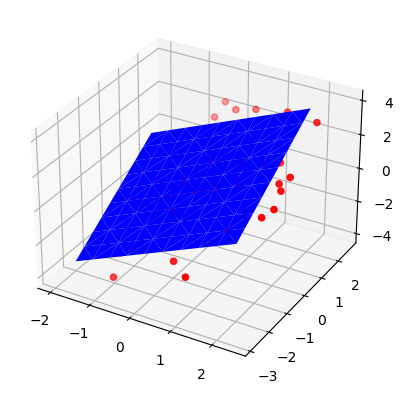

In [ ]:
#@title create data
N_train = 100 # @param {type:"number"}
X_train = torch.randn((N_train, 2))
# Define the lambda function to operate on rows
# true_func = lambda row: torch.sin(torch.sqrt(row[0] * row[0] + row[1] * row[1]))
true_func = lambda row: row[0] + row[1]
# true_func = lambda row: (row[0])**2 + (row[1])**2
# Apply the lambda function to each row of X_train
noise_scale = 0.0 # @param {type:"number"}
Y_train = torch.tensor([true_func(row) for row in X_train]) + noise_scale*torch.randn((N_train))


##### create a grid = cartesian product #####

# Define the coordinates for the two points
x1, y1 = -2, -2  # Point 1
x2, y2 = 2, 2  # Point 2

# Number of points in each dimension
N_points = 10 # @param {type:"number"}
# Generate linearly spaced values between x1 and x2, and y1 and y2
x_values = torch.linspace(x1, x2, N_points)
y_values = torch.linspace(y1, y2, N_points)

grid = torch.cartesian_prod(x_values, y_values)
Y_grid = torch.tensor([true_func(row) for row in grid])


##### Plot #####
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# NOTE: https://stackoverflow.com/questions/51574861/plotting-3d-surface-using-python-raise-valueerrorargument-z-must-be-2-dimensi
ax.plot_trisurf(grid.numpy()[:,0], grid.numpy()[:,1], Y_grid.numpy(), color = "blue", zorder=1)
ax.scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train.numpy(), color = "red", zorder=2)

plt.show()

In [ ]:
#@title define torch NN
# sequential_net = nn.Sequential(nn.Linear(2,32),
#                                nn.ReLU(),
#                                nn.Linear(32,64),
#                                nn.ReLU(),
#                                nn.Linear(64,128),
#                                nn.ReLU(),
#                                nn.Linear(128,64),
#                                nn.ReLU(),
#                                nn.Linear(64,1))

def get_model(N_neurons = int(2**3)):
  model = nn.Sequential(nn.Linear(2,N_neurons),
                                nn.ReLU(),
                                nn.Linear(N_neurons,1))
  # set to ntk parametrization
  for layer in model:
    if not isinstance(layer, nn.ReLU):
      # print(layer.weight)
      torch.nn.init.kaiming_normal_(layer.weight, nonlinearity = "linear")
  return model


sequential_net = get_model()

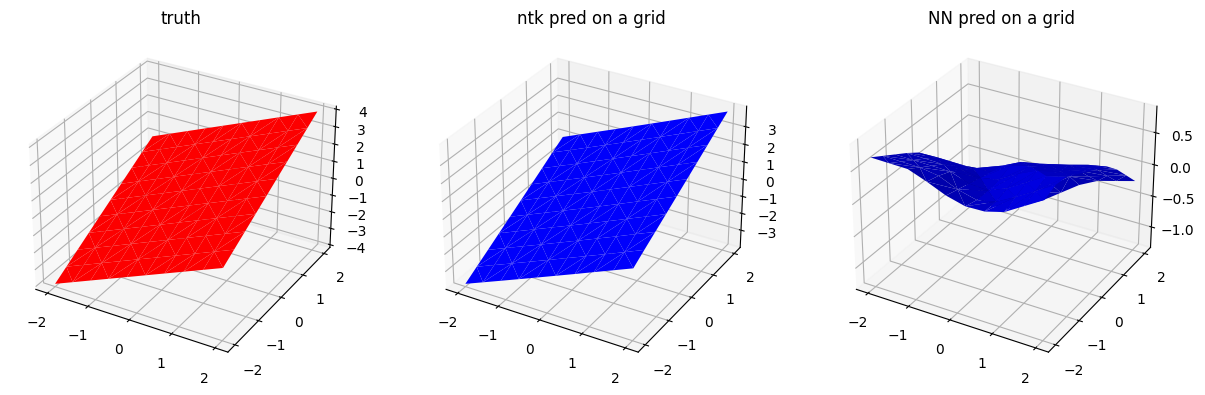

In [ ]:
#@title NTK pred on grid for given net

init_fn, apply_fn, kernel_fn = torchSeq_to_staxSeq(sequential_net)



K_matrix = kernel_fn(X_train.numpy(), X_train.numpy(), 'ntk')
# predict_fn = nt.predict.gradient_descent_mse(K_matrix, Y_train.numpy())

K_inverse = jax.numpy.linalg.inv(K_matrix)

K_test = kernel_fn(grid.numpy(), X_train.numpy(), 'ntk')

alpha = K_inverse @ Y_train.numpy()
predictions = (K_test) @ alpha
# predictions = predict_fn(x_test=grid.numpy(), get='ntk')

##### Plot #####
# Create a figure and explicitly add 3D subplots
fig = plt.figure(figsize=(15, 5))
# Add each 3D subplot
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

# truth
ax1.plot_trisurf(grid.numpy()[:,0], grid.numpy()[:,1], Y_grid.numpy(), color = "red", zorder=1)
# ntk pred
ax2.plot_trisurf(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "blue", zorder=1)
# ax2.scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "blue", zorder=1)
# nn pred
predictions_nn = sequential_net(grid).squeeze().detach().cpu()
ax3.plot_trisurf(grid.numpy()[:,0], grid.numpy()[:,1], predictions_nn, color = "blue", zorder=1)


# # get points with topk \alpha_i * k(x, x_i) for a fixed x in green and the topk value in red
# selected_gridPoint_index = 0 # @param {type:"number"}
# k_value = 1 # @param {type:"number"}
# # get index of training point that have topk \alpha_i * k(x, x_i)
# topk_points = torch.tensor(np.argpartition( K_test[selected_gridPoint_index] * alpha, -k_value)[-k_value:])
# # plot this points
# ax2.scatter(grid[selected_gridPoint_index][0], grid[selected_gridPoint_index][1], Y_grid[selected_gridPoint_index], s=50, color = "green", alpha=1, zorder=3) # plot fixed selected_gridPoint_index in green
# print("topk points indexis: ",topk_points)
# ax2.scatter(X_train[topk_points][:, 0], X_train[topk_points][:, 1], Y_train[topk_points], color = "red", s=50, alpha=1, zorder=3) # plot topk

ax1.set_title("truth")
ax2.set_title("ntk pred on a grid")
ax3.set_title("NN pred on a grid")
plt.show()

In [ ]:
predictions.shape

(2500,)

In [ ]:
# sanity check argpartition
a = np.array([1,-5,150,5,-8,6,-8,4,2,0,-20,89])
top = np.argpartition(a, -5)[-5:]
# print(top)
print(a[top])

[  4   5   6 150  89]


In [ ]:
# Create a TensorDataset
train_dataset = TensorDataset(X_train, Y_train)

# Create a DataLoader
batch_size = len(train_dataset)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(sequential_net.parameters(), lr = 0.001)

In [ ]:
losses= list()
val = list()

sequential_net.train()
N_epochs = 1000
for epoch in range(N_epochs): # 5 or 8
  running_loss = 0
  for i, batch in enumerate(train_loader):
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device).squeeze()

    optimizer.zero_grad()

    out = sequential_net(inputs).squeeze()
    loss = criterion(out, labels)

    loss.backward()


    optimizer.step()

    running_loss += loss.item()

    # if i % 10 == 9:    # print every 10 mini-batches

    # append val acc.
    losses.append(running_loss)
    # val.append(perf(validloader))


    # print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses[-1]:.3f}, val_accuracy: {val[-1]: .4f}')
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses[-1]:.3f}')
    plt.plot(losses, color = "blue")
    # plt.loglog(val, color = "red")
    plt.show()

    # reset record variables
    running_loss = 0.0



print('Finished Training')

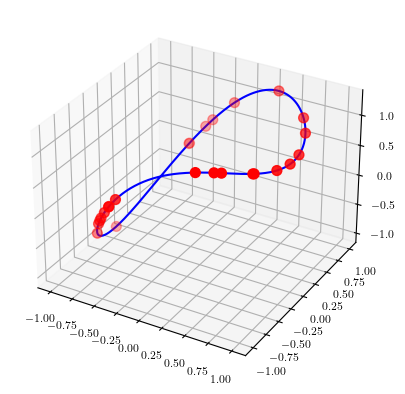

In [ ]:
#@title generate data on S^2

#@title create data
N_train = 25 # @param {type:"number"}
X_train = torch.tensor([ [torch.cos(x), torch.sin(x)] for x in 2* np.pi * torch.rand(size = (N_train,))])
# Define the lambda function to operate on rows
# true_func = lambda row: torch.sin(torch.sqrt(row[0] * row[0] + row[1] * row[1]))
# true_func = lambda row: (row[0] + row[1])**2 # another good/easy func
# true_func = lambda row: torch.cos(5*row[0]) + torch.cos(5*row[1])
# true_func = lambda row: torch.cos(10*row[0]) + torch.cos(10*row[1])
true_func = lambda row: row[0] + row[1]**2 # used in main plot
# true_func = lambda row: (row[0])**2 + (row[1])**2
# Apply the lambda function to each row of X_train
noise_scale = 0.0 # @param {type:"number"}
Y_train = torch.tensor([true_func(row) for row in X_train]) + noise_scale*torch.randn((N_train))


##### create a grid = cartesian product #####



# Number of points in each dimension
N_points = 500 # @param {type:"number"}
# Generate linearly spaced values between x1 and x2, and y1 and y2
values = torch.linspace(0, 2*np.pi, N_points).unsqueeze(-1)
cos_values = torch.cos(values)
sin_values = torch.sin(values)

grid = torch.cat([cos_values, sin_values], dim = 1)
Y_grid = torch.tensor([true_func(row) for row in grid])


##### Plot #####
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# NOTE: https://stackoverflow.com/questions/51574861/plotting-3d-surface-using-python-raise-valueerrorargument-z-must-be-2-dimensi
ax.plot(grid.numpy()[:,0], grid.numpy()[:,1], Y_grid.numpy(), color = "blue", zorder=1)
ax.scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train.numpy(), color = "red", zorder=2, s = 50)

plt.show()

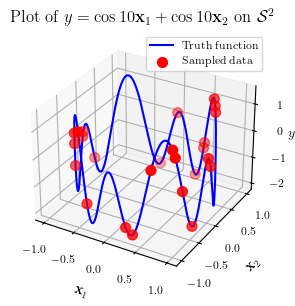

In [ ]:
#@title load data

# Set up LaTeX parameters for plots
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.rcParams.update(tex_fonts)
# load X_train
with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/EPOCHS:120_000_000-run0" + f"/X_train_10cos", 'rb') as f:
    X_train = pickle.load(f)

N_train = X_train.size(0)
true_func = lambda row: torch.cos(10*row[0]) + torch.cos(10*row[1])
# true_func = lambda row: row[0] + row[1]**2 # used in main plot
# true_func = lambda row: (row[0])**2 + (row[1])**2
# Apply the lambda function to each row of X_train
noise_scale = 0.0 # @param {type:"number"}
Y_train = torch.tensor([true_func(row) for row in X_train]) + noise_scale*torch.randn((N_train))


##### create a grid = cartesian product #####



# Number of points in each dimension
N_points = 500 # @param {type:"number"}
# Generate linearly spaced values between x1 and x2, and y1 and y2
values = torch.linspace(0, 2*np.pi, N_points).unsqueeze(-1)
cos_values = torch.cos(values)
sin_values = torch.sin(values)

grid = torch.cat([cos_values, sin_values], dim = 1)
Y_grid = torch.tensor([true_func(row) for row in grid])


##### Plot #####
fig = plt.figure(figsize=set_size(380.69788))
ax = fig.add_subplot(projection='3d')

# NOTE: https://stackoverflow.com/questions/51574861/plotting-3d-surface-using-python-raise-valueerrorargument-z-must-be-2-dimensi
ax.plot(grid.numpy()[:,0], grid.numpy()[:,1], Y_grid.numpy(), color = "blue", zorder=1, label=r'Truth function')
ax.scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train.numpy(), color = "red", zorder=2, s = 50, label=r'Sampled data')

plt.xlabel(r'$\mathbf{x}_1$')
plt.ylabel(r'$\mathbf{x}_2$')
ax.set_zlabel(r'$y$')
ax.zaxis.labelpad=-4

plt.title(r'Plot of $y = \cos{10\mathbf{x}_1} + \cos{10\mathbf{x}_2}$ on $\mathcal{S}^2$')
plt.legend(loc='best')

# plt.tight_layout()
plt.savefig("cosine_data.pdf", format='pdf', bbox_inches='tight')
plt.show()

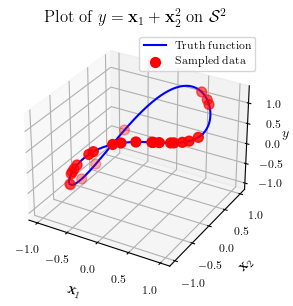

In [ ]:
#@title load data squared

# Set up LaTeX parameters for plots
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.rcParams.update(tex_fonts)
# load X_train
with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/X_train_squared", 'rb') as f:
    X_train = pickle.load(f)

N_train = X_train.size(0)
# true_func = lambda row: torch.cos(10*row[0]) + torch.cos(10*row[1])
true_func = lambda row: row[0] + row[1]**2 # used in main plot
# true_func = lambda row: (row[0])**2 + (row[1])**2
# Apply the lambda function to each row of X_train
noise_scale = 0.0 # @param {type:"number"}
Y_train = torch.tensor([true_func(row) for row in X_train]) + noise_scale*torch.randn((N_train))


##### create a grid = cartesian product #####



# Number of points in each dimension
N_points = 500 # @param {type:"number"}
# Generate linearly spaced values between x1 and x2, and y1 and y2
values = torch.linspace(0, 2*np.pi, N_points).unsqueeze(-1)
cos_values = torch.cos(values)
sin_values = torch.sin(values)

grid = torch.cat([cos_values, sin_values], dim = 1)
Y_grid = torch.tensor([true_func(row) for row in grid])


##### Plot #####
fig = plt.figure(figsize=set_size(380.69788))
ax = fig.add_subplot(projection='3d')

# NOTE: https://stackoverflow.com/questions/51574861/plotting-3d-surface-using-python-raise-valueerrorargument-z-must-be-2-dimensi
ax.plot(grid.numpy()[:,0], grid.numpy()[:,1], Y_grid.numpy(), color = "blue", zorder=1, label=r'Truth function')
ax.scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train.numpy(), color = "red", zorder=2, s = 50, label=r'Sampled data')

plt.xlabel(r'$\mathbf{x}_1$')
plt.ylabel(r'$\mathbf{x}_2$')
ax.set_zlabel(r'$y$')
ax.zaxis.labelpad=-4

plt.title(r'Plot of $y = \mathbf{x}_1 + \mathbf{x}_2^2$ on $\mathcal{S}^2$')
plt.legend(loc='best')

# plt.tight_layout()
plt.savefig("squared_data.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
#@title define torch NN
# sequential_net = nn.Sequential(nn.Linear(2,32),
#                                nn.ReLU(),
#                                nn.Linear(32,64),
#                                nn.ReLU(),
#                                nn.Linear(64,128),
#                                nn.ReLU(),
#                                nn.Linear(128,64),
#                                nn.ReLU(),
#                                nn.Linear(64,1))

def get_model(N_neurons = int(2**11)):
  model = nn.Sequential(nn.Linear(2,N_neurons, bias = None),
                                nn.ReLU(),
                                nn.Linear(N_neurons, 1, bias = None))
  # model = nn.Sequential(nn.Linear(2,N_neurons, bias = None),
  #                             nn.ReLU(),
  #                             nn.Linear(N_neurons,N_neurons, bias = None),
  #                             nn.ReLU(),
  #                             nn.Linear(N_neurons, 1, bias = None))
  # model = nn.Sequential(nn.Linear(2,N_neurons, bias = None),
  #                           nn.ReLU(),
  #                           nn.Linear(N_neurons,N_neurons, bias = None),
  #                           nn.ReLU(),
  #                           nn.Linear(N_neurons,N_neurons, bias = None),
  #                           nn.ReLU(),
  #                           nn.Linear(N_neurons, 1, bias = None))

  # set to ntk parametrization
  for i, layer in enumerate(model):
    if not isinstance(layer, nn.ReLU) and i!=1:
      # print(layer.weight)
      torch.nn.init.kaiming_normal_(layer.weight, nonlinearity = "relu")
  return model


sequential_net = get_model()

In [ ]:
#@title NTK with formulas : Sanity check

def phi(c):
  c = np.clip(c, a_min = -1.0, a_max = 1.0)
  return (1/(np.pi)) * (np.sqrt(1-c**2)+(np.pi-np.arccos(c))*c)

def dot_phi(c):
  c = np.clip(c, a_min = -1.0, a_max = 1.0)
  return (1/(np.pi)) * (np.pi - np.arccos(c))

def kernel_train(n):
  kernel_matrix = torch.zeros((n, n), dtype = torch.float64)
  # naive implementation
  for i in range(n):
    for j in range(n):
      c = torch.dot(X_train[i], X_train[j])
      kernel_matrix[i, j] = phi(c) + dot_phi(c) * c

  return kernel_matrix

def kernel_test(n, m):
  kernel_matrix = torch.zeros((n, m), dtype = torch.float64)
  # naive implementation
  for i in range(n):
    for j in range(m):
      c = torch.dot(grid[i], X_train[j])
      kernel_matrix[i, j] = phi(c) + dot_phi(c) * c

  return kernel_matrix

K_m = kernel_train(n = N_train).numpy()
K_t = kernel_test(n = N_points, m = N_train).numpy()

In [ ]:
K_m

AttributeError: 'jaxlib.xla_extension.ArrayImpl' object has no attribute 'numpy'

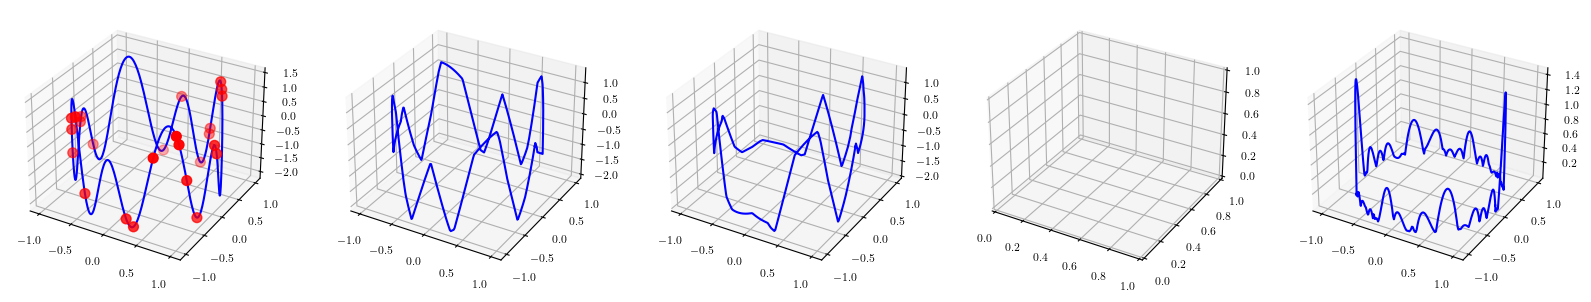

In [ ]:
#@title NTK pred on circle for given net

init_fn, apply_fn, kernel_fn = torchSeq_to_staxSeq(sequential_net)
# _, _, kernel_fn = stax.serial(stax.Dense(10, b_std=0.0),
#                               stax.Relu(),
#                               stax.Dense(1, b_std=0.0))



K_matrix = kernel_fn(X_train.numpy(), X_train.numpy(), 'ntk')
# predict_fn = nt.predict.gradient_descent_mse(K_matrix, Y_train.numpy())

K_inverse = jax.numpy.linalg.inv(K_matrix)

K_test = kernel_fn(grid.numpy(), X_train.numpy(), 'ntk')

alpha = K_inverse @ Y_train.numpy()
predictions = (K_test) @ alpha
# predictions = predict_fn(x_test=grid.numpy(), get='ntk')

##### Plot #####
# Create a figure and explicitly add 3D subplots
fig = plt.figure(figsize=(20, 10))
# Add each 3D subplot
ax1 = fig.add_subplot(151, projection='3d')
ax2 = fig.add_subplot(152, projection='3d')
ax3 = fig.add_subplot(153, projection='3d')
ax4 = fig.add_subplot(154, projection='3d')
ax5 = fig.add_subplot(155, projection='3d')

if type(predictions_nn) == list:
  predictions_nn = predictions_nn[-1]

#### truth
# ax1.plot(grid.numpy()[:,0], grid.numpy()[:,1], Y_grid.numpy(), color = "red", zorder=1)
ax1.plot(grid.numpy()[:,0], grid.numpy()[:,1], Y_grid.numpy(), color = "blue", zorder=1)
ax1.scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train.numpy(), color = "red", zorder=2, s = 50)
#### ntk pred
ax2.plot(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "blue", zorder=1)
ax5.plot(grid.numpy()[:,0], grid.numpy()[:,1], np.abs(predictions-Y_grid.numpy()), color = "blue", zorder=1)
# ax2.scatter(grid.numpy()[:,0], grid.numpy()[:,1], Y_grid.numpy(), color = "red", zorder=1)
#### nn pred
sequential_net = sequential_net.cpu()
# predictions_nn = sequential_net(grid).squeeze().detach().cpu()
ax3.plot(grid.numpy()[:,0], grid.numpy()[:,1], predictions_nn, color = "blue", zorder=1)
# plot difference between pred by nn and ntk
predictions_dif = np.abs(predictions-predictions_nn.numpy())
ax4.plot(grid.numpy()[:,0], grid.numpy()[:,1], predictions_dif, color = "blue", zorder=1)

# # get points with topk \alpha_i * k(x, x_i) for a fixed x in green and the topk value in red
# selected_gridPoint_index = 400 # @param {type:"number"}
# k_value = 5 # @param {type:"number"}
# # get index of training point that have topk \alpha_i * k(x, x_i)
# topk_points = torch.tensor(np.argpartition( K_test[selected_gridPoint_index] * alpha, -k_value)[-k_value:])
# # plot this points
# ax2.scatter(grid[selected_gridPoint_index][0], grid[selected_gridPoint_index][1], Y_grid[selected_gridPoint_index], s=50, color = "green", alpha=1, zorder=3) # plot fixed selected_gridPoint_index in green
# print("topk points indexis: ",topk_points)
# ax2.scatter(X_train[topk_points][:, 0], X_train[topk_points][:, 1], Y_train[topk_points], color = "red", s=50, alpha=1, zorder=3) # plot topk

ax1.set_title("truth")
ax2.set_title("ntk pred on a circle")
ax3.set_title("NN pred on a circle")
ax4.set_title("ntk pred - NN pred")
ax5.set_title("ntk - truth")
plt.show()

In [ ]:
# Create a TensorDataset
train_dataset = TensorDataset(X_train, Y_train)

# Create a DataLoader
batch_size = len(train_dataset)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
#@title v0 train
def train(N_neurons = int(2**9), N_epochs = 1_000, lr = 0.0001, resume = False): # 0.00001, 1500000
  losses= list()
  predictions_nn = list()

  sequential_net = get_model(N_neurons = N_neurons).to(device)
  sequential_net.train()
  if resume:
    # sequential_net.load_state_dict(torch.load(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(N_neurons)}_10cos_params.pt"))
    sequential_net.load_state_dict(torch.load(f"/NN_{int(N_neurons)}_10cos_params.pt"))

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(sequential_net.parameters(), lr = lr)

  predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())

  for epoch in range(N_epochs): # 5 or 8
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
      inputs, labels = batch
      inputs, labels = inputs.to(device), labels.to(device).squeeze()

      optimizer.zero_grad()

      out = sequential_net(inputs).squeeze()
      loss = criterion(out, labels)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()

      # if i % 10 == 9:    # print every 10 mini-batches

      # append val acc.
      losses.append(running_loss)
      # val.append(perf(validloader))

      # if epoch % 500000 == 499999:
      #   # print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses[-1]:.3f}, val_accuracy: {val[-1]: .4f}')
      #   print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses[-1]:.3f}')
      #   # print(torch.min(sequential_net[-1].weight.data), torch.max(sequential_net[-1].weight.data))
      #   plt.loglog(losses, color = "blue")
      #   # plt.loglog(val, color = "red")
      #   plt.show()

      #   predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())


      # reset record variables
      running_loss = 0.0



  print('Finished Training')

  predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())

  return sequential_net, predictions_nn, losses


sequential_net, predictions_nn, losses = train(N_neurons = int(2**11), N_epochs = 100_000, lr = 0.00001, resume = True)

In [ ]:
#@title SGD

# Create a TensorDataset
train_dataset = TensorDataset(X_train, Y_train)

# Create a DataLoader
batch_size = 5
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

def train(N_neurons = int(2**9), N_epochs = 1_000, lr = 0.0001, resume = False): # 0.00001, 1500000
  losses= list()
  predictions_nn = list()

  sequential_net = get_model(N_neurons = N_neurons).to(device)
  sequential_net.train()
  if resume:
    sequential_net.load_state_dict(torch.load(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(N_neurons)}_10cos_params.pt"))

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(sequential_net.parameters(), lr = lr)

  predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())

  for epoch in tqdm(range(N_epochs)): # 5 or 8
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
      inputs, labels = batch
      inputs, labels = inputs.to(device), labels.to(device).squeeze()

      optimizer.zero_grad()

      out = sequential_net(inputs).squeeze()
      loss = criterion(out, labels)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()

      losses.append(running_loss)

      # if epoch % 500_000 == 499_999:    # print every 10 mini-batches

      # append val acc.

      # val.append(perf(validloader))

      if epoch % 1_000 == 999:
        # print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses[-1]:.3f}, val_accuracy: {val[-1]: .4f}')
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses[-1]:.8f}')
        # print(torch.min(sequential_net[-1].weight.data), torch.max(sequential_net[-1].weight.data))
        plt.loglog(losses, color = "blue")
        # plt.loglog(val, color = "red")
        plt.show()

      #   predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())


      # reset record variables
      running_loss = 0.0



  print('Finished Training')

  predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())

  return sequential_net, predictions_nn, losses


sequential_net, predictions_nn, losses = train(N_neurons = int(2**5), N_epochs = 7_000_000, lr = 0.00005)

  0%|          | 0/10000 [00:00<?, ?it/s]

[1000,     1] loss: 0.63890731


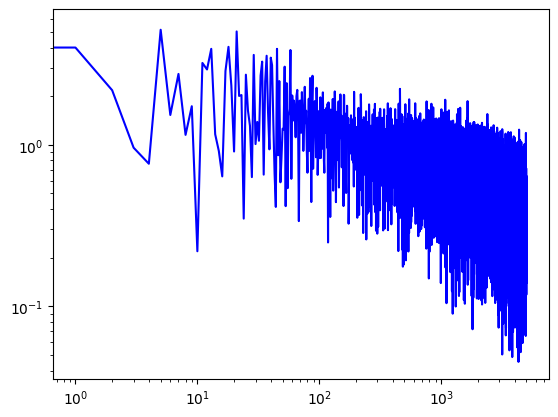

[1000,     2] loss: 0.11886757


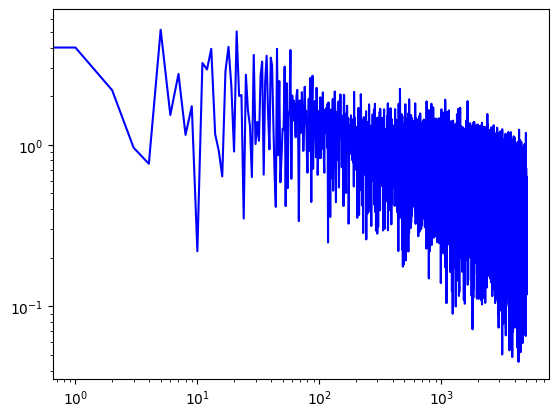

[1000,     3] loss: 0.58335805


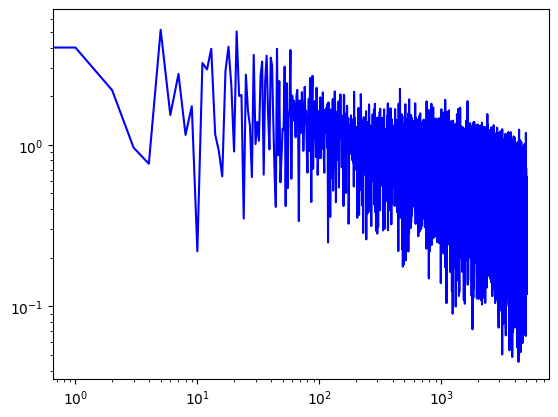

[1000,     4] loss: 0.41288519


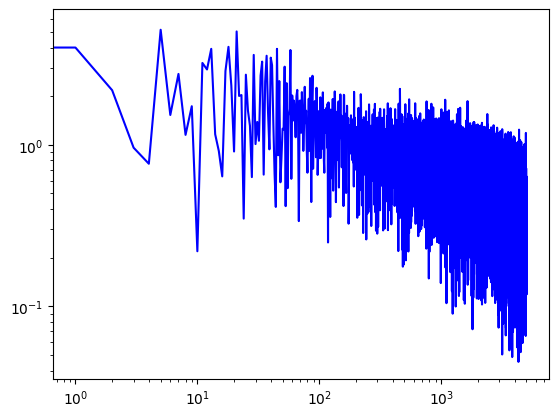

[1000,     5] loss: 0.20883718


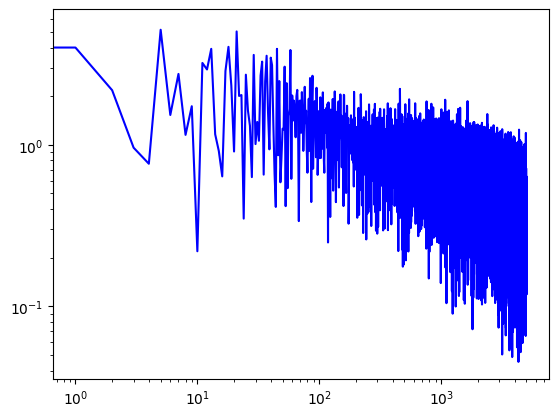

[2000,     1] loss: 0.11336694


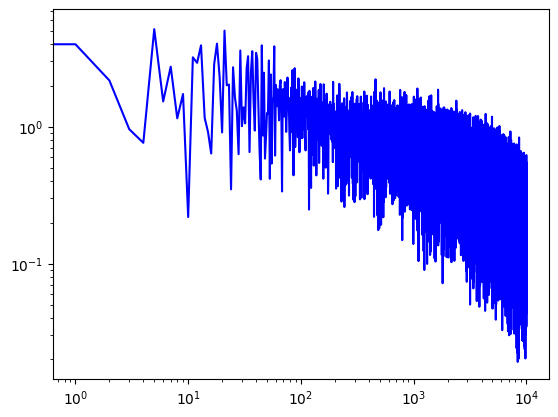

[2000,     2] loss: 0.22530942


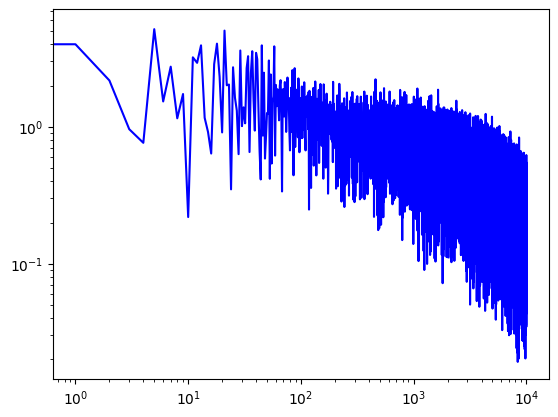

[2000,     3] loss: 0.23843180


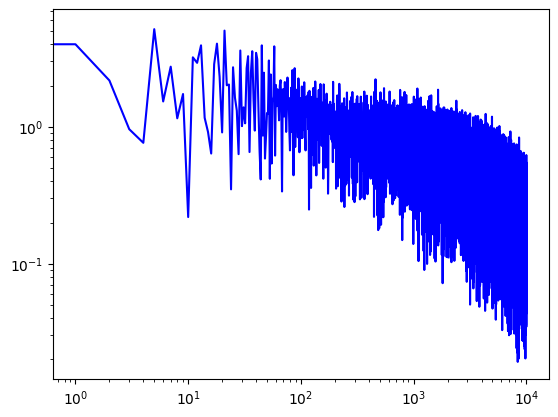

[2000,     4] loss: 0.19931889


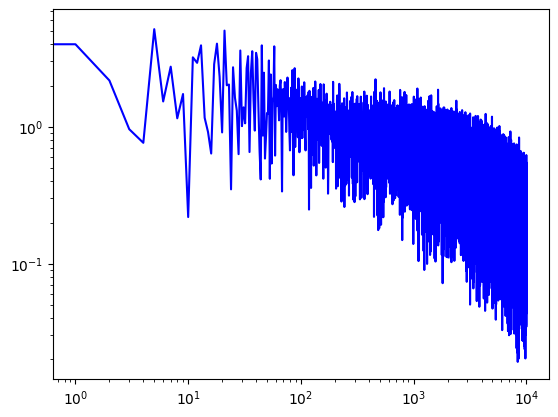

[2000,     5] loss: 0.30525395


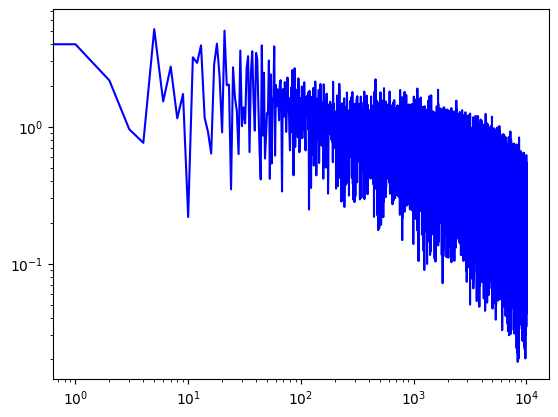

[3000,     1] loss: 0.04114212


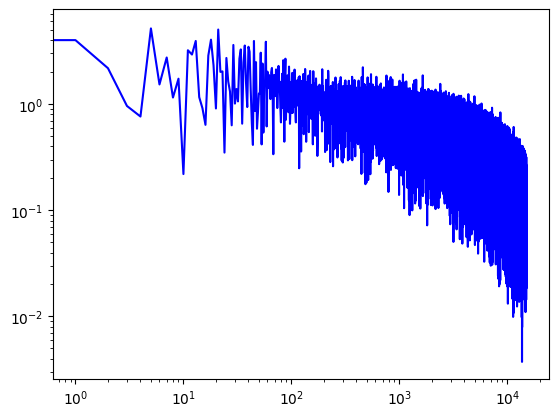

[3000,     2] loss: 0.06971692


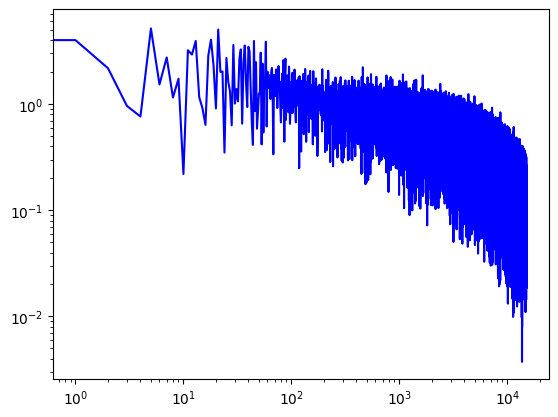

[3000,     3] loss: 0.13340352


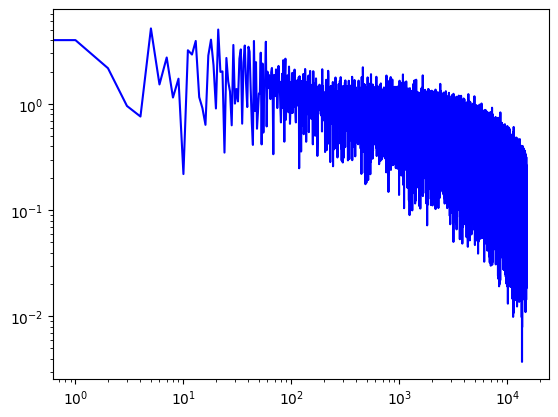

[3000,     4] loss: 0.08984669


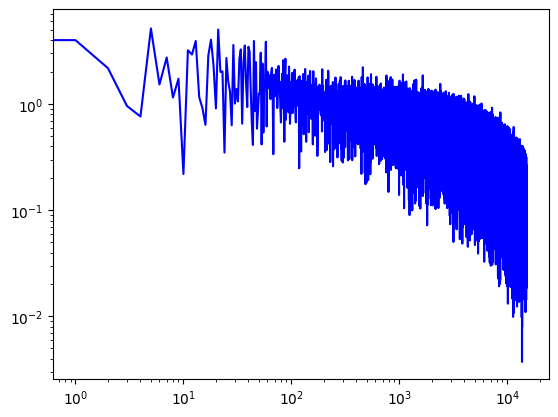

[3000,     5] loss: 0.23137811


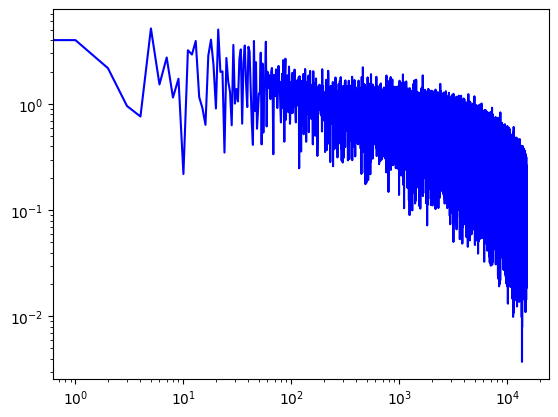

[4000,     1] loss: 0.05266758


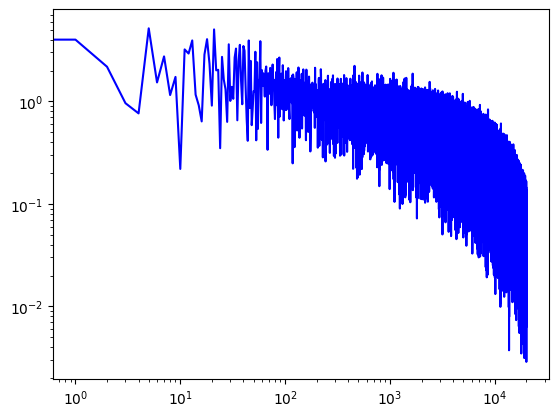

[4000,     2] loss: 0.01682676


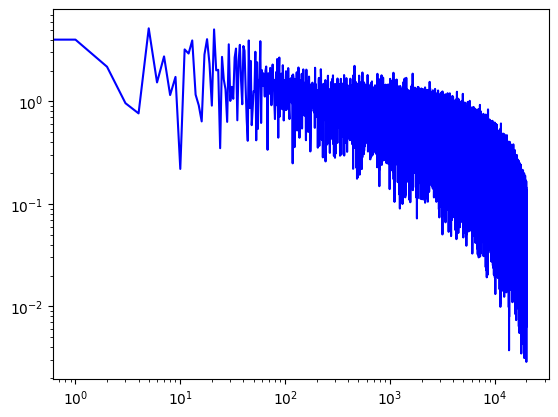

[4000,     3] loss: 0.12347653


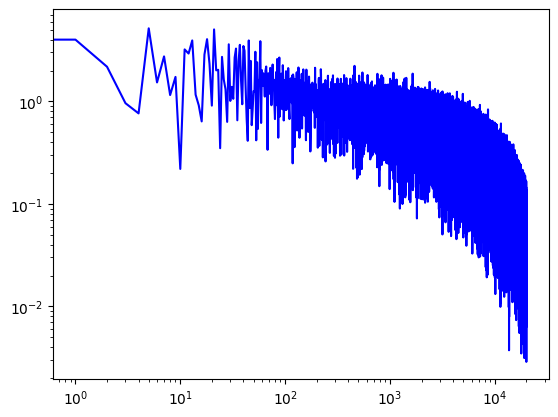

[4000,     4] loss: 0.02673298


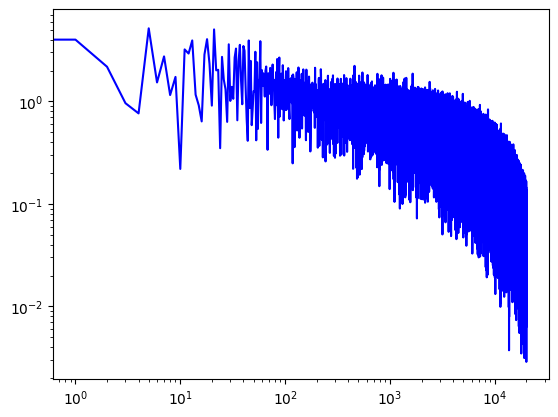

[4000,     5] loss: 0.03601575


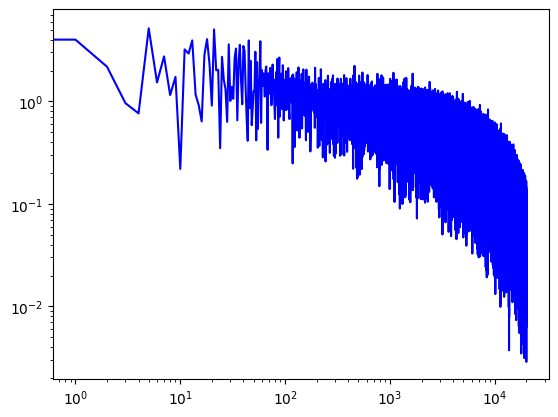

[5000,     1] loss: 0.02743725


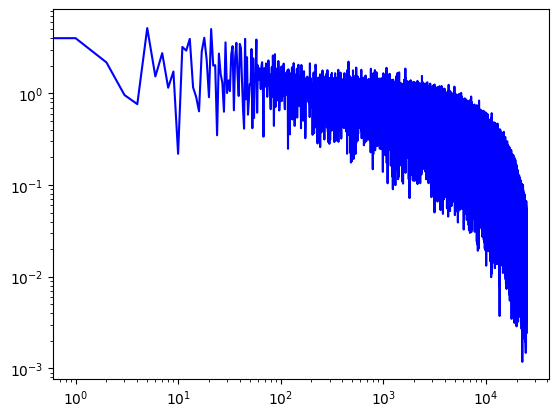

[5000,     2] loss: 0.01002465


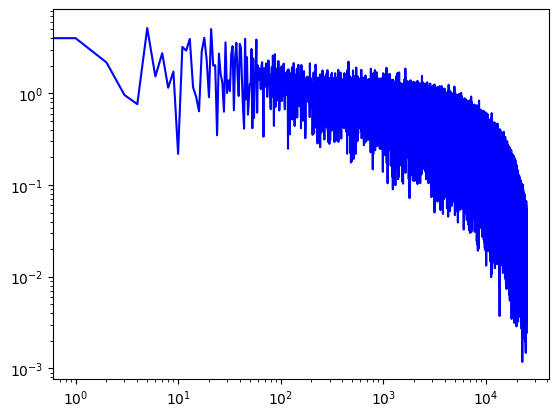

[5000,     3] loss: 0.03663126


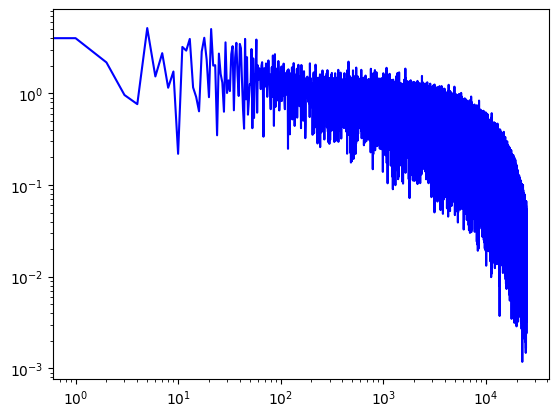

[5000,     4] loss: 0.01971214


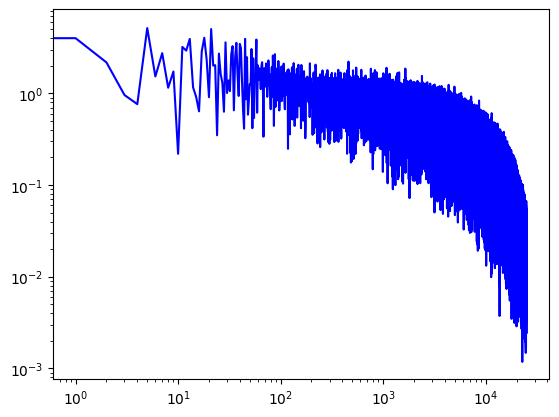

[5000,     5] loss: 0.00433948


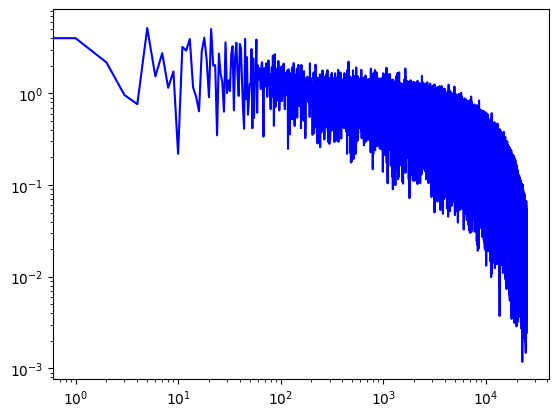

[6000,     1] loss: 0.00607891


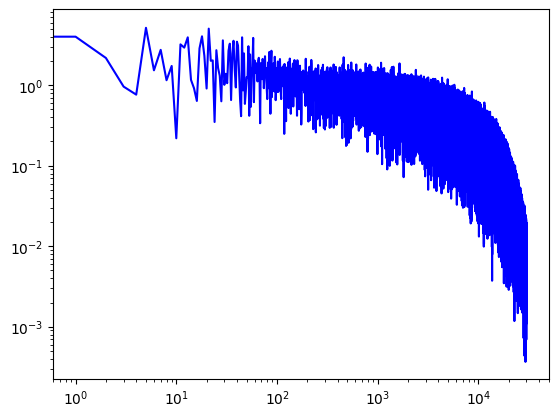

[6000,     2] loss: 0.00812268


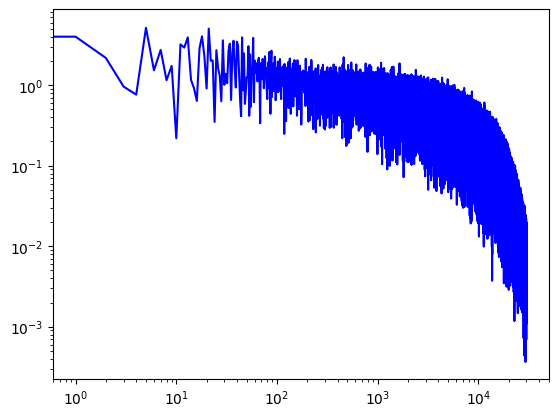

[6000,     3] loss: 0.01295961


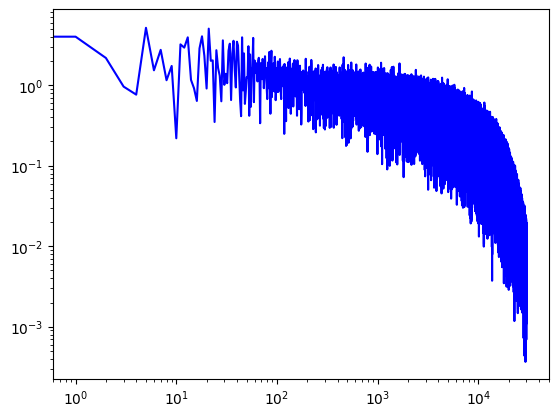

[6000,     4] loss: 0.00583691


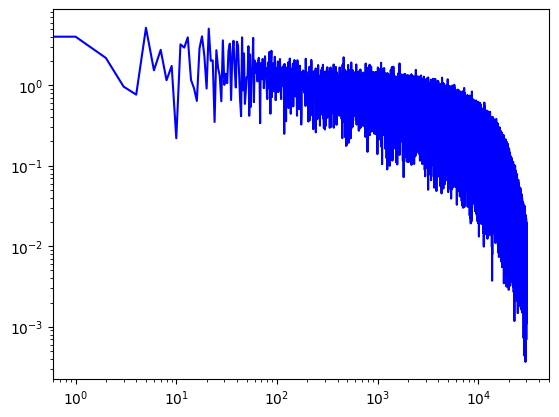

[6000,     5] loss: 0.00443513


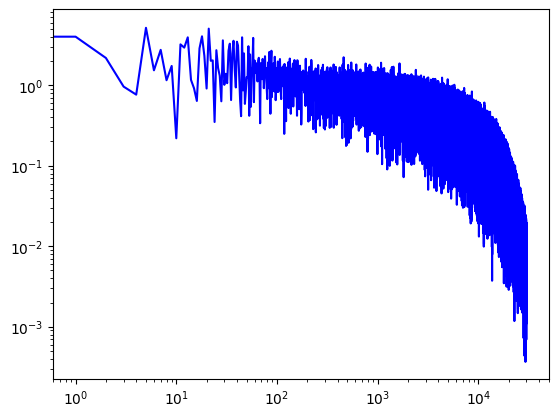

[7000,     1] loss: 0.00225116


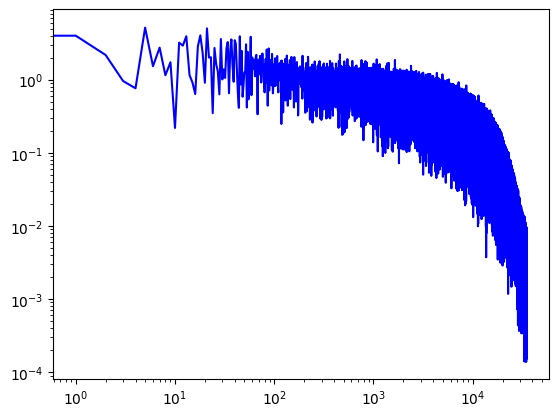

[7000,     2] loss: 0.00354990


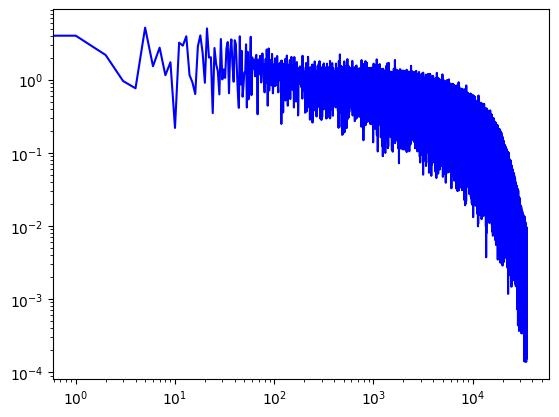

[7000,     3] loss: 0.00296759


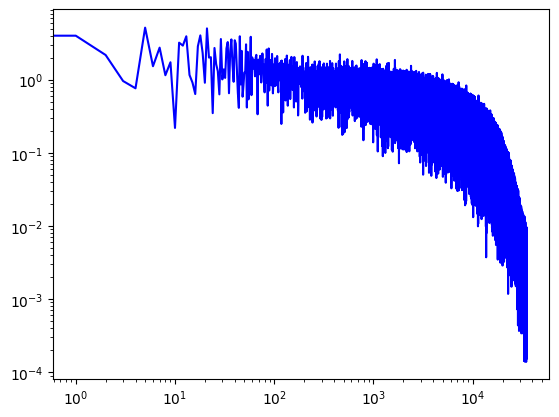

[7000,     4] loss: 0.00575251


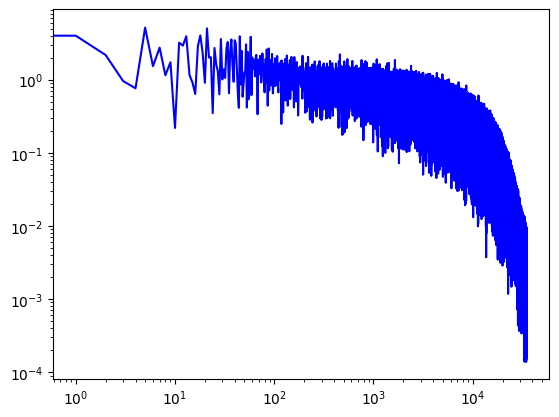

[7000,     5] loss: 0.00202416


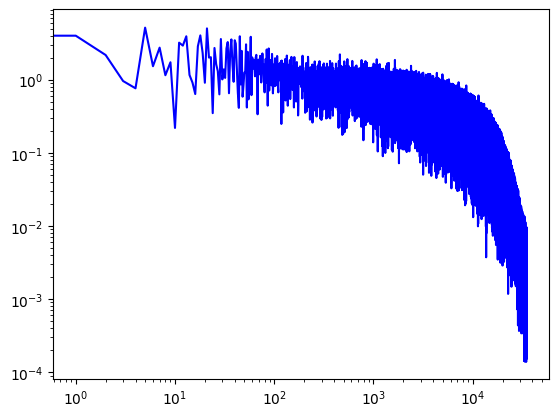

[8000,     1] loss: 0.00139570


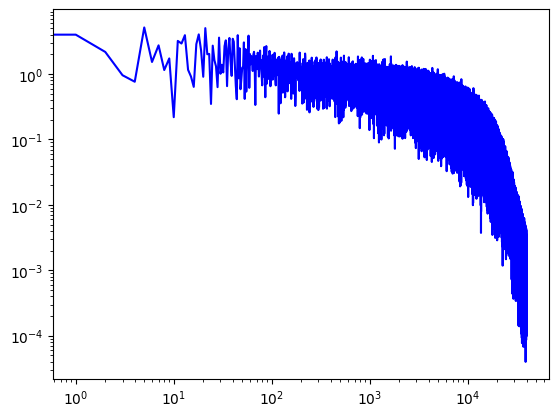

[8000,     2] loss: 0.00103063


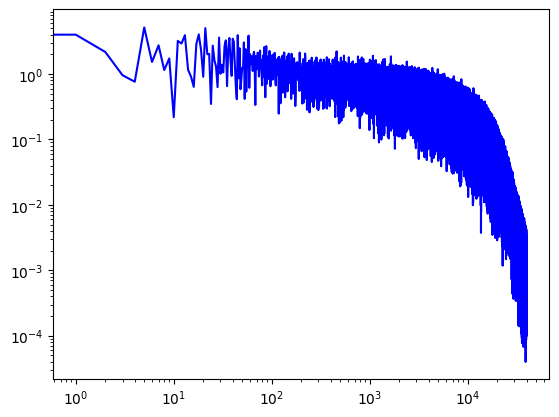

[8000,     3] loss: 0.00010463


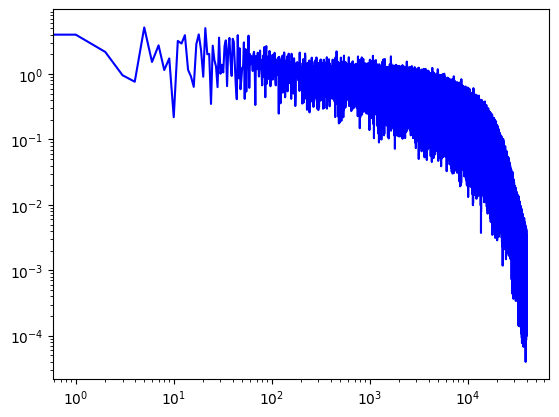

[8000,     4] loss: 0.00073254


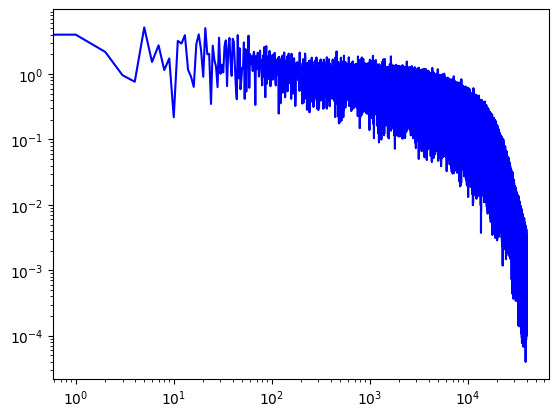

[8000,     5] loss: 0.00213952


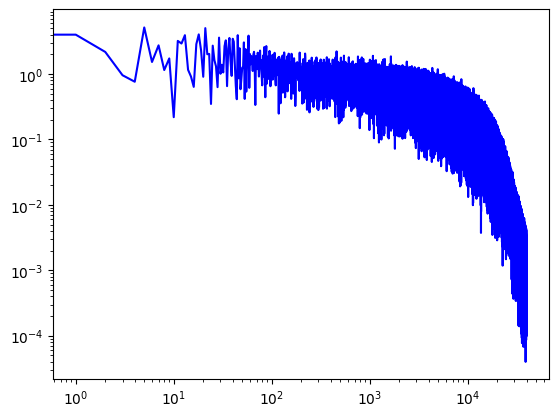

[9000,     1] loss: 0.00030195


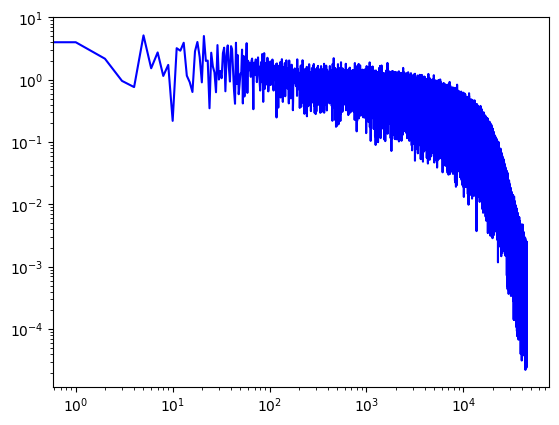

[9000,     2] loss: 0.00014908


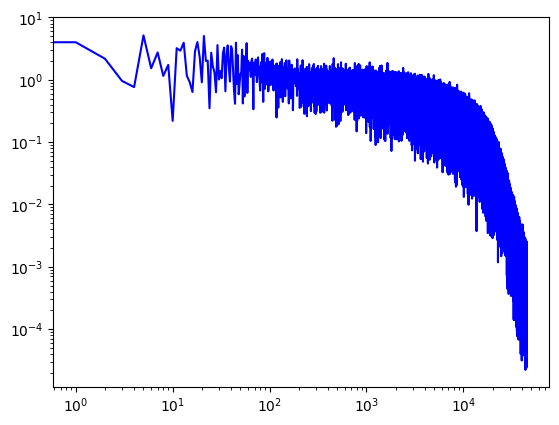

[9000,     3] loss: 0.00076514


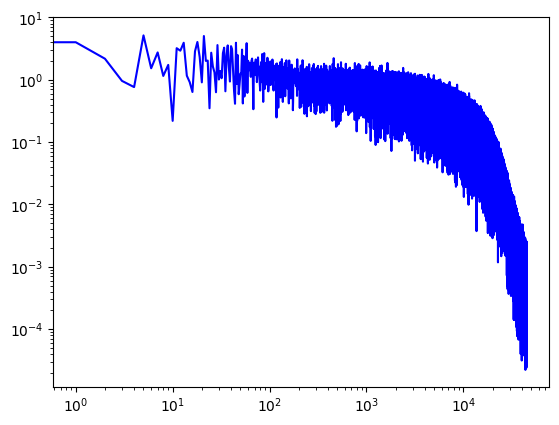

[9000,     4] loss: 0.00076350


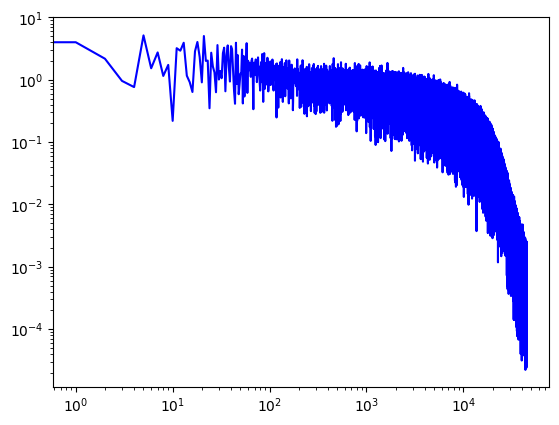

[9000,     5] loss: 0.00170082


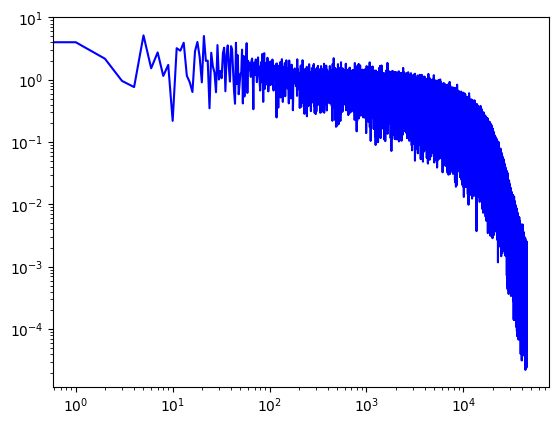

[10000,     1] loss: 0.00036621


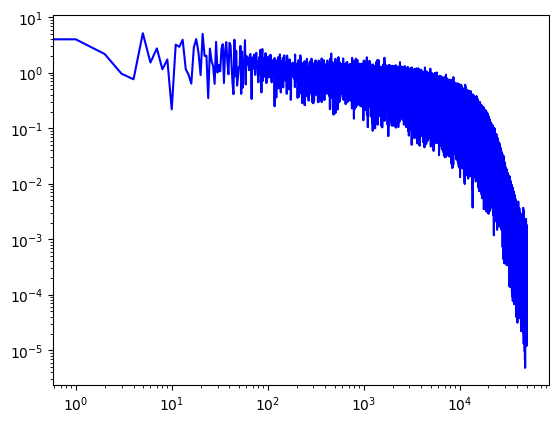

[10000,     2] loss: 0.00019283


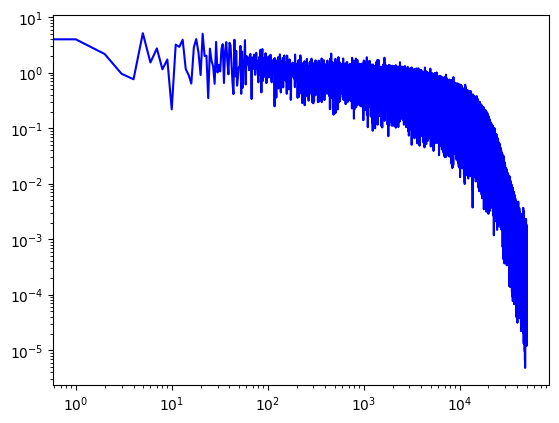

[10000,     3] loss: 0.00048424


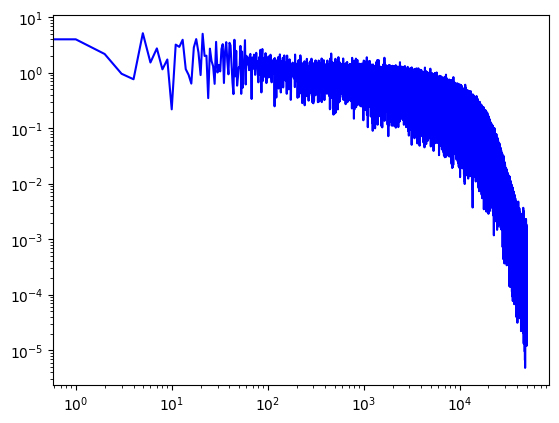

[10000,     4] loss: 0.00124625


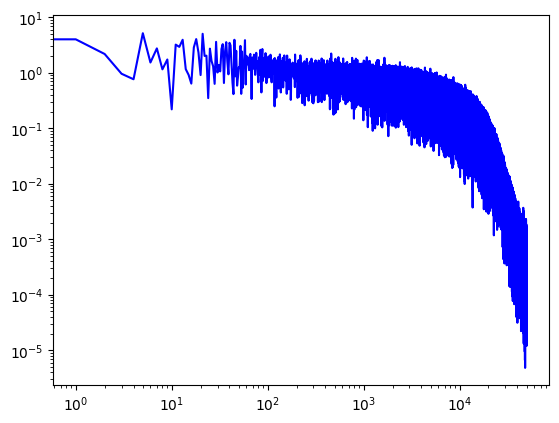

[10000,     5] loss: 0.00057382


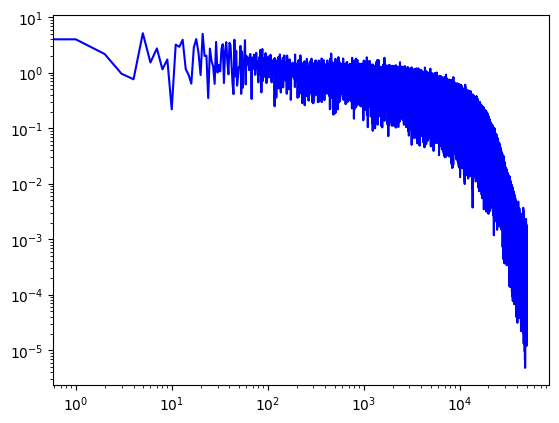

Finished Training


In [ ]:
#@title Adam

# Create a TensorDataset
train_dataset = TensorDataset(X_train, Y_train)

# Create a DataLoader
batch_size = 5
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

def train(N_neurons = int(2**9), N_epochs = 1_000, lr = 0.0001, resume = False): # 0.00001, 1500000
  losses= list()
  predictions_nn = list()

  sequential_net = torch.compile(get_model(N_neurons = N_neurons)).to(device)
  sequential_net.train()
  if resume:
    # sequential_net.load_state_dict(torch.load(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(N_neurons)}_10cos_params.pt"))
    sequential_net.load_state_dict(torch.load(f"/NN_{int(N_neurons)}_10cos_params.pt"))

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(sequential_net.parameters(), lr = lr)

  predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())

  for epoch in tqdm(range(N_epochs)): # 5 or 8
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
      inputs, labels = batch
      inputs, labels = inputs.to(device), labels.to(device).squeeze()

      optimizer.zero_grad()

      out = sequential_net(inputs).squeeze()
      loss = criterion(out, labels)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()

      losses.append(running_loss)

      # if epoch % 500_000 == 499_999:    # print every 10 mini-batches

      # append val acc.

      # val.append(perf(validloader))

      if epoch % 1_000 == 999:
        # print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses[-1]:.3f}, val_accuracy: {val[-1]: .4f}')
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses[-1]:.8f}')
        # print(torch.min(sequential_net[-1].weight.data), torch.max(sequential_net[-1].weight.data))
        plt.loglog(losses, color = "blue")
        # plt.loglog(val, color = "red")
        plt.show()

      #   predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())


      # reset record variables
      running_loss = 0.0



  print('Finished Training')

  predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())

  return sequential_net, predictions_nn, losses

size = int(2**11)
sequential_net, predictions_nn, losses = train(N_neurons = size, N_epochs = 10_000, lr = 0.00005)

# torch.save(sequential_net.state_dict(), f"NN_{size}_10cos_params.pt")

In [ ]:
# train loop with some speed improvement.
def train(N_neurons = int(2**9), N_epochs = 500_000, lr = 0.0001, resume = False): # 0.00001, 1500000
  losses= list()
  predictions_nn = list()

  sequential_net = get_model(N_neurons = N_neurons).to(device)
  sequential_net.train()
  if resume:
    # sequential_net.load_state_dict(torch.load(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(N_neurons)}_10cos_params.pt"))
    sequential_net.load_state_dict(torch.load(f"/NN_{int(N_neurons)}_10cos_params.pt"))

  criterion = nn.MSELoss()
  optimizer = torch.optim.SGD(sequential_net.parameters(), lr = lr)

  # predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())
  inputs, labels = next(iter(train_loader))
  inputs, labels  = inputs.to(device), labels.to(device).squeeze()

  for epoch in tqdm(range(N_epochs)): # 5 or 8

    # optimizer.zero_grad()
    for param in sequential_net.parameters():
      param.grad = None

    out = sequential_net(inputs).squeeze()
    loss = criterion(out, labels)

    loss.backward()

    optimizer.step()

    losses.append(loss.item())


  print('Finished Training')

  predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())

  return sequential_net, predictions_nn, losses

# sequential_net, predictions_nn, losses = train(N_neurons = int(2**11), N_epochs = 80_000, lr = 0.00001, resume = True)

In [ ]:
# Adam without plotting.

# Create a TensorDataset
train_dataset = TensorDataset(X_train, Y_train)

# Create a DataLoader
batch_size = 5
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

def train(N_neurons = int(2**9), N_epochs = 30_000, lr = 0.0001, resume = False): # 0.00001, 1500000
  losses= list()
  predictions_nn = list()

  sequential_net = torch.compile(get_model(N_neurons = N_neurons)).to(device)
  sequential_net.train()
  if resume:
    # sequential_net.load_state_dict(torch.load(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(N_neurons)}_10cos_params.pt"))
    sequential_net.load_state_dict(torch.load(f"/NN_{int(N_neurons)}_10cos_params.pt"))

  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(sequential_net.parameters(), lr = lr)

  predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())

  for epoch in tqdm(range(N_epochs)): # 5 or 8
    running_loss = 0.0
    for i, batch in enumerate(train_loader):
      inputs, labels = batch
      inputs, labels = inputs.to(device), labels.to(device).squeeze()

      optimizer.zero_grad()

      out = sequential_net(inputs).squeeze()
      loss = criterion(out, labels)

      loss.backward()

      optimizer.step()

      running_loss += loss.item()

      losses.append(running_loss)

      # if epoch % 500_000 == 499_999:    # print every 10 mini-batches

      # append val acc.

      # val.append(perf(validloader))

      # if epoch % 1_000 == 999:
      #   # print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses[-1]:.3f}, val_accuracy: {val[-1]: .4f}')
      #   print(f'[{epoch + 1}, {i + 1:5d}] loss: {losses[-1]:.8f}')
      #   # print(torch.min(sequential_net[-1].weight.data), torch.max(sequential_net[-1].weight.data))
      #   plt.loglog(losses, color = "blue")
      #   # plt.loglog(val, color = "red")
      #   plt.show()

      #   predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())


      # reset record variables
      running_loss = 0.0



  print('Finished Training')

  predictions_nn.append(sequential_net(grid.to(device)).squeeze().detach().cpu())

  return sequential_net, predictions_nn, losses

In [ ]:
device = torch.device('cpu')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
torch.set_num_threads(2)

In [ ]:
torch.set_float32_matmul_precision('high')

In [ ]:
start = time.time()
sequential_net, predictions_nn, losses = train(N_neurons = int(2**10), N_epochs = 24_000_000, lr = 0.0001)
print(time.time()-start)

In [ ]:
#@title train loop on different net size and save data

def loop_train(sizes_list = [2], lrs = [0.01], resume = False):

  assert len(sizes_list) == len(lrs)

  for lr, size in zip(lrs, sizes_list):
    sequential_net, predictions_nn, losses = train(N_neurons = int(size), lr = lr, resume = resume)
    # save nn pred list
    with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(size)}_10cos_pred", 'wb') as f:
        pickle.dump(predictions_nn, f)
    # save nn loss list
    with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(size)}_10cos_loss", 'wb') as f:
        pickle.dump(losses, f)
    # save nn parameters
    # torch.save(sequential_net.state_dict(), folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(size)}_10cos_params.pt")

# sizes = [int(2**i) for i in range(3,13,2)]
# loop_train(sizes_list = sizes, lrs = [0.0001,0.0001,0.0001,0.00001,0.000001])
# sizes = [int(2**10)]
# loop_train(sizes_list = sizes, lrs = [0.00001], resume = True)

# sizes = [int(2**12)]
# loop_train(sizes_list = sizes, lrs = [0.000001], resume = True)
# sizes = [32,128,512,2048]
# loop_train(sizes_list = sizes, lrs = [0.0001,0.0001,0.0001,0.00001])

sizes = [1000,10000,100000,1000000]
loop_train(sizes_list = sizes, lrs = [0.0001,0.0001,0.00001,0.000001])

  0%|          | 0/30000 [00:00<?, ?it/s]

Finished Training


  0%|          | 0/30000 [00:00<?, ?it/s]

Finished Training


OutOfMemoryError: CUDA out of memory. Tried to allocate 37.25 GiB. GPU 

In [ ]:
#@title parallel cpu cores training

import multiprocessing as mp
ctx = mp.get_context('spawn')

def run_one_instance(args):
    idx, params = args
    N_neurons, lr = params[idx]
    print(idx)
    sys.stdout.flush()
    # sequential_net, predictions_nn, losses = train(N_neurons = int(N_neurons), lr = lr, N_epochs = 1_000)

    # # save nn pred list
    # with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(N_neurons)}_10cos_pred", 'wb') as f:
    #     pickle.dump(predictions_nn, f)
    # # save nn loss list
    # with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(N_neurons)}_10cos_loss", 'wb') as f:
    #     pickle.dump(losses, f)
    # # save nn parameters
    # torch.save(sequential_net.state_dict(), folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(N_neurons)}_10cos_params.pt")

    return True

def run_multiple_instances(num_instances = 1):
    lr_list = [0.0001,0.0001,0.0001,0.00001,0.000001]
    layer_sizes = [int(2**i) for i in range(3,13,2)]
    params = list(zip(lr_list, layer_sizes))

    pool_obj = ctx.Pool()
    result = pool_obj.map(run_one_instance, [(i, params) for i in range(num_instances)])

    return result

result = run_multiple_instances()

In [ ]:
import multiprocessing as mp
import sys

ctx = mp.get_context('spawn')

def run_one_instance(args):
    idx, params = args
    N_neurons, lr = params[idx]
    print(f"Index: {idx}, N_neurons: {N_neurons}, lr: {lr}")
    sys.stdout.flush()  # Ensure the output is flushed immediately
    # sequential_net, predictions_nn, losses = train(N_neurons = int(N_neurons), lr = lr, N_epochs = 1_000)

    # # save nn pred list
    # with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(N_neurons)}_10cos_pred", 'wb') as f:
    #     pickle.dump(predictions_nn, f)
    # # save nn loss list
    # with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(N_neurons)}_10cos_loss", 'wb') as f)
    #     pickle.dump(losses, f)
    # # save nn parameters
    # torch.save(sequential_net.state_dict(), folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(N_neurons)}_10cos_params.pt")

    return True

def run_multiple_instances(num_instances=1):
    lr_list = [0.0001, 0.0001, 0.0001, 0.00001, 0.000001]
    layer_sizes = [int(2**i) for i in range(3, 13, 2)]
    params = list(zip(lr_list, layer_sizes))

    print("Parameters:", params)
    sys.stdout.flush()

    with ctx.Pool() as pool:
        result = pool.map(run_one_instance, [(i, params) for i in range(num_instances)])

    return result

if __name__ == "__main__":
    result = run_multiple_instances()
    print("Result:", result)


In [ ]:
predictions_nn

In [ ]:
name = f"NN_{4096}_10cos"

In [ ]:
# save prediction NTK
with open(folder_path +f"/supNorm_ntkpred_and_fnnpred" + f"/NTK_pred_10cos", 'wb') as f:
    pickle.dump(predictions, f)

In [ ]:
# save prediction DATA
with open(folder_path +f"/supNorm_ntkpred_and_fnnpred" + f"/X_train_squared", 'wb') as f:
    pickle.dump(X_train, f)

In [ ]:
# save nn pred
with open(folder_path + f"/{name}", 'wb') as f:
    pickle.dump(predictions_nn, f)

In [ ]:
# load
with open(folder_path +f"/supNorm_ntkpred_and_fnnpred" + f"/{name}_pred", 'rb') as f:
    predictions_nn = pickle.load(f)

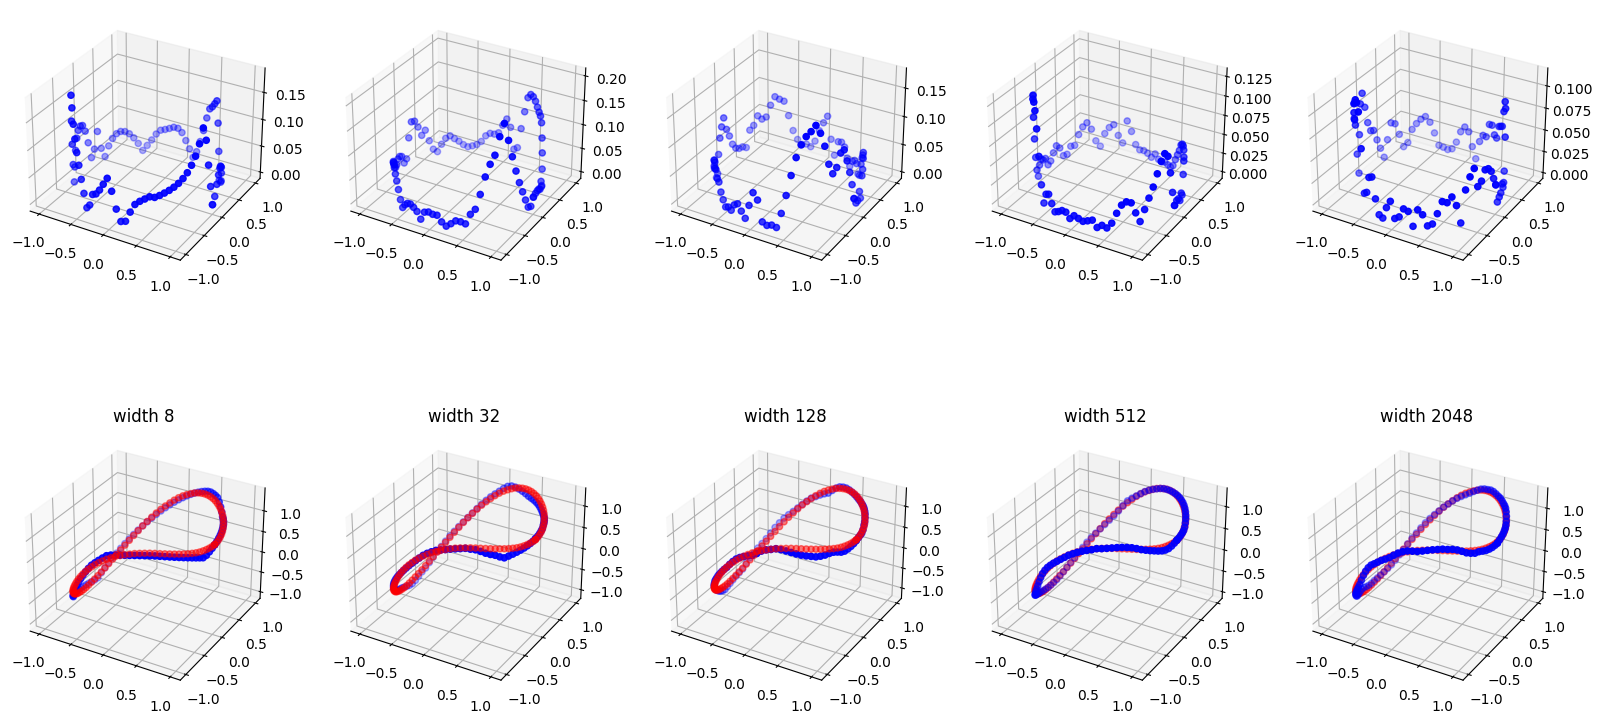

In [ ]:
#@title plot of all NTk pred - NN pred for different network width

##### Plot #####
# Create a figure and explicitly add 3D subplots
fig = plt.figure(figsize=(20, 20))
# Add each 3D subplot
N_subplots = 2*5
axs = []
for i in range(N_subplots):
    # Calculate the correct subplot index
    row = i // 5 + 1
    col = i % 5 + 1
    axs.append(fig.add_subplot(row, 5, col, projection='3d'))

# get all predictions_nn data
sizes = [2**3, 2**5, 2**7, 2**9, 2**11]
predictions_nn_list = []
for i in sizes:
  name = f"NN_{int(i)}"
  with open(folder_path + f"/{name}", 'rb') as f:
    predictions_nn_list.append(pickle.load(f))

# plot second line
for i in range(N_subplots//2):
  predictions_nn = predictions_nn_list[i]
  axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions_nn, color = "blue", zorder=1)
  axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "red", zorder=1, alpha = 0.5)

# plot first line
for i in range(N_subplots//2, N_subplots):
  predictions_nn = predictions_nn_list[i-5]
  predictions_dif = np.abs(predictions-predictions_nn.numpy())
  axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions_dif, color = "blue", zorder=1)


# set titles

for i in range(N_subplots//2):
  axs[i].set_title(f"width {sizes[i]}")

# plt.tight_layout()
plt.show()

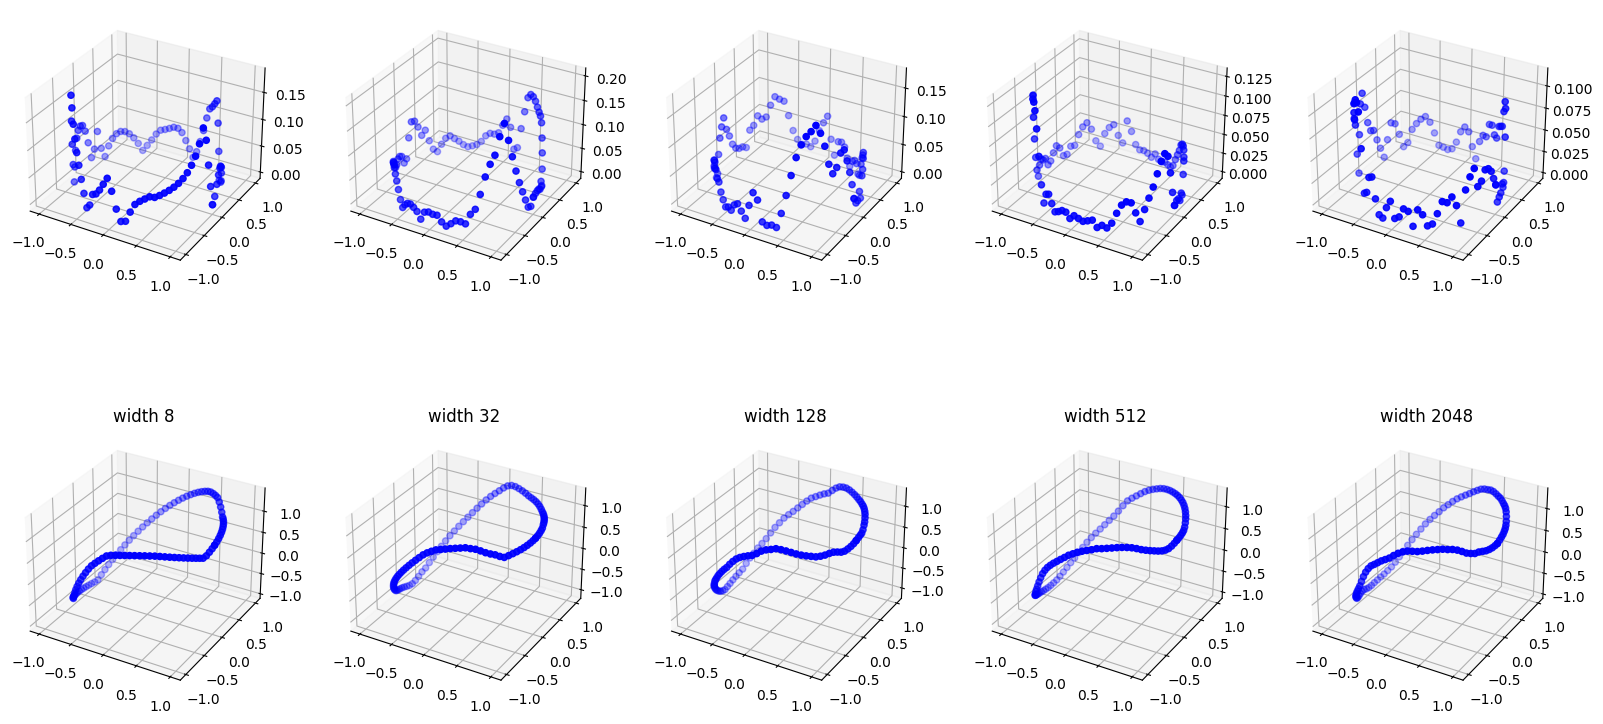

In [ ]:
#@title plot of all NTk pred - NN pred for different network width

##### Plot #####
# Create a figure and explicitly add 3D subplots
fig = plt.figure(figsize=(20, 20))
# Add each 3D subplot
N_subplots = 2*5
axs = []
for i in range(N_subplots):
    # Calculate the correct subplot index
    row = i // 5 + 1
    col = i % 5 + 1
    axs.append(fig.add_subplot(row, 5, col, projection='3d'))

# get all predictions_nn data
sizes = [2**3, 2**5, 2**7, 2**9, 2**11]
predictions_nn_list = []
for i in sizes:
  name = f"NN_{int(i)}"
  with open(folder_path + f"/{name}", 'rb') as f:
    predictions_nn_list.append(pickle.load(f))

# plot second line
for i in range(N_subplots//2):
  predictions_nn = predictions_nn_list[i]
  axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions_nn, color = "blue", zorder=1)
  # axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "red", zorder=1, alpha = 0.5)

# plot first line
for i in range(N_subplots//2, N_subplots):
  predictions_nn = predictions_nn_list[i-5]
  predictions_dif = np.abs(predictions-predictions_nn.numpy())
  axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions_dif, color = "blue", zorder=1)


# set titles

for i in range(N_subplots//2):
  axs[i].set_title(f"width {sizes[i]}")

# plt.tight_layout()
plt.show()

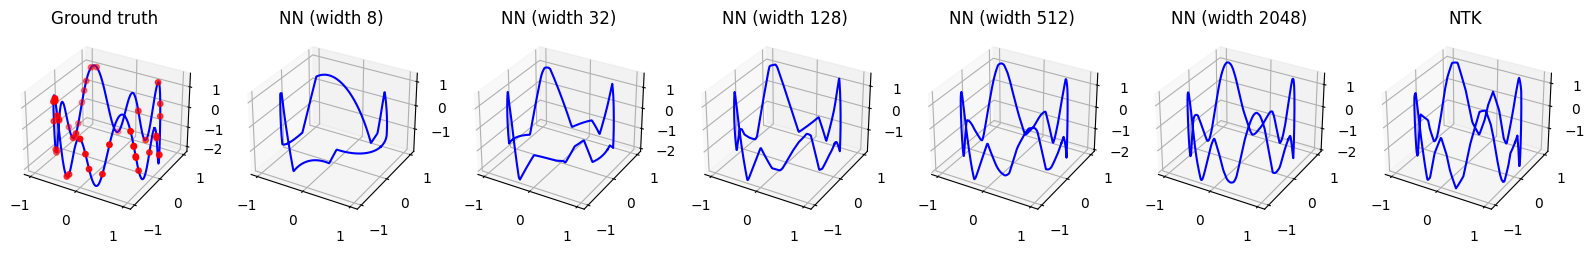

In [ ]:
#@title plot of all NN pred for different network width

##### Plot #####
# Create a figure and explicitly add 3D subplots
fig = plt.figure(figsize=(20, 20))
# Add each 3D subplot
N_subplots = 5+1+1
axs = []
for i in range(N_subplots):
    # Calculate the correct subplot index
    axs.append(fig.add_subplot(1, N_subplots, i+1, projection='3d'))

# get all predictions_nn data
sizes = [2**3, 2**5, 2**7, 2**9, 2**11]
predictions_nn_list = [Y_grid]
for i in sizes:
  name = f"NN_{int(i)}_10cos"
  with open(folder_path + f"/{name}", 'rb') as f:
    predictions_nn_list.append(pickle.load(f))
predictions_nn_list.append(predictions) # append NTK predictions

# plot
for i in range(N_subplots):
  predictions_nn = predictions_nn_list[i]
  axs[i].plot(grid.numpy()[:,0], grid.numpy()[:,1], predictions_nn, color = "blue", zorder=1)
  # axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "red", zorder=1, alpha = 0.5)
axs[0].scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train, color = "red", zorder=2, s = 15)

# set titles
for i in range(1, N_subplots-1):
  axs[i].set_title(f"NN (width {sizes[i-1]})")
axs[0].set_title(f"Ground truth")
axs[-1].set_title(f"NTK")
# plt.tight_layout()
# plt.savefig("ntkVSnn.jpeg")
plt.show()

In [ ]:
#@title plot of |nn-ntk|_inf for different network width

##### Plot #####
# Create a figure
N_subplots = 4
fig, axs = plt.subplots(1, N_subplots, figsize=(20, 4))


# get all predictions_nn data
predictions_nn_list = []
sizes = [int(2**i) for i in range(5,13,2)]
for i in sizes:
  name = f"NN_{int(i)}_10cos"
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(i)}_10cos_pred", 'rb') as f:
    predictions_nn_list.append(pickle.load(f))


# plot error
EPOCHS = 30_000_000
for i in range(N_subplots):
  predictions_nn = predictions_nn_list[i]
  predictions_nn.pop()
  supNorm_difference_pred = [np.max(np.abs(predictions_nn_epoch.numpy() - predictions)) for predictions_nn_epoch in predictions_nn]
  axs[i].plot(range(0, EPOCHS+500_000, 500_000), supNorm_difference_pred, color = "blue")


# # set titles
for i in range(N_subplots):
  axs[i].set_title(f"NN (width {sizes[i]})")
plt.tight_layout()
# plt.savefig("ntkVSnn.jpeg")
plt.show()

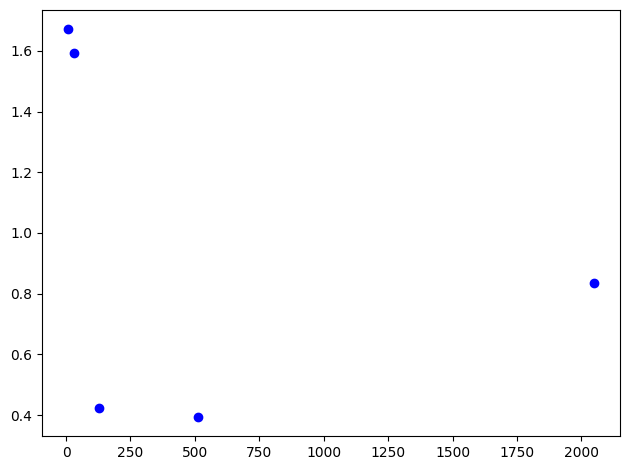

In [ ]:
#@title plot of |nn-ntk|_inf for different network width

##### Plot #####
# Create a figure

fig, axs = plt.subplots(1, 1)

# get all predictions_nn data
predictions_nn_list = []
sizes = [int(2**i) for i in range(3,13,2)]
for i in sizes:
  name = f"NN_{int(i)}_10cos"
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(i)}_10cos_pred", 'rb') as f:
    predictions_nn_list.append(pickle.load(f))
# get last element of predictions_nn_list and compute error
predictions_nn_list = [predictions_nn[-1] for predictions_nn in predictions_nn_list]
supNorm_difference_pred = [np.max(np.abs(predictions_nn_epoch.numpy() - predictions)) for predictions_nn_epoch in predictions_nn_list]

#plot
axs.scatter(sizes, supNorm_difference_pred,color = "blue")

plt.tight_layout()
# plt.savefig("ntkVSnn.jpeg")
plt.show()

In [ ]:
len(predictions_nn_list[0])

1

In [ ]:
#@title plot of |nn-ntk|_inf for different network width

##### Plot #####
# Create a figure
N_subplots = 4
fig, axs = plt.subplots(1, N_subplots, figsize=(20, 4))


# get all predictions_nn data
predictions_nn_list = []
sizes = [int(2**i) for i in range(5,13,2)]
for i in sizes:
  name = f"NN_{int(i)}_10cos"
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(i)}_10cos_pred", 'rb') as f:
    predictions_nn_list.append(pickle.load(f))


# plot error
EPOCHS = 30_000_000
for i in range(N_subplots):
  predictions_nn = predictions_nn_list[i]
  predictions_nn.pop()
  supNorm_difference_pred = [np.max(np.abs(predictions_nn_epoch.numpy() - predictions)) for predictions_nn_epoch in predictions_nn]
  axs[i].plot(range(0, EPOCHS+500_000, 500_000), supNorm_difference_pred, color = "blue")


# # set titles
for i in range(N_subplots):
  axs[i].set_title(f"NN (width {sizes[i]})")
plt.tight_layout()
# plt.savefig("ntkVSnn.jpeg")
plt.show()

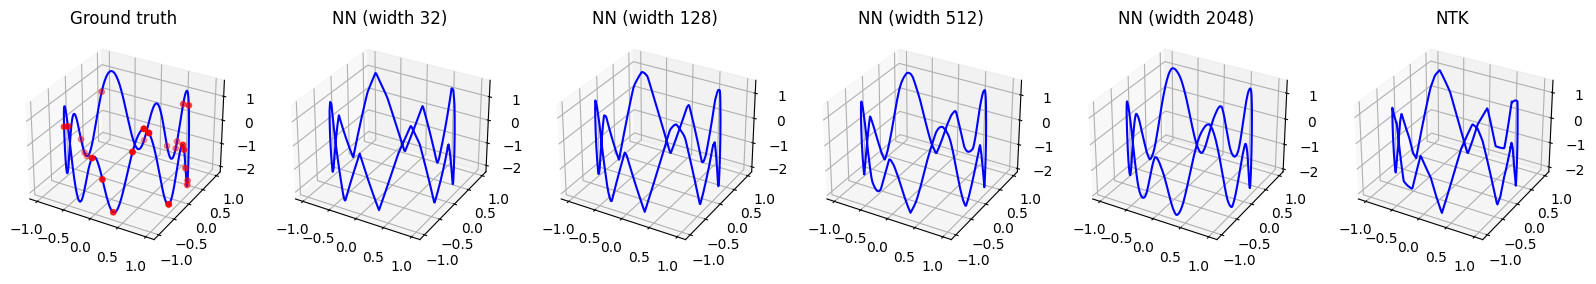

In [ ]:
#@title plot of all NN pred for different network width (Adapted version)

##### Plot #####
# Create a figure and explicitly add 3D subplots
fig = plt.figure(figsize=(20, 20))
# Add each 3D subplot
N_subplots = 4+1+1
axs = []
for i in range(N_subplots):
    # Calculate the correct subplot index
    axs.append(fig.add_subplot(1, N_subplots, i+1, projection='3d'))

# get all predictions_nn data
sizes = [int(2**i) for i in range(5,13,2)]
predictions_nn_list = [Y_grid]
for i in sizes:
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(i)}_10cos_pred", 'rb') as f:
    predictions_nn_list.append(pickle.load(f)[-1])
predictions_nn_list.append(predictions) # append NTK predictions

# plot
for i in range(N_subplots):
  predictions_nn = predictions_nn_list[i]
  axs[i].plot(grid.numpy()[:,0], grid.numpy()[:,1], predictions_nn, color = "blue", zorder=1)
  # axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "red", zorder=1, alpha = 0.5)
axs[0].scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train, color = "red", zorder=2, s = 15)

# set titles
for i in range(1, N_subplots-1):
  axs[i].set_title(f"NN (width {sizes[i-1]})")
axs[0].set_title(f"Ground truth")
axs[-1].set_title(f"NTK")
# plt.tight_layout()
# plt.savefig("ntkVSnn.jpeg")
plt.show()

In [ ]:
sizes

[32, 128, 512, 2048]

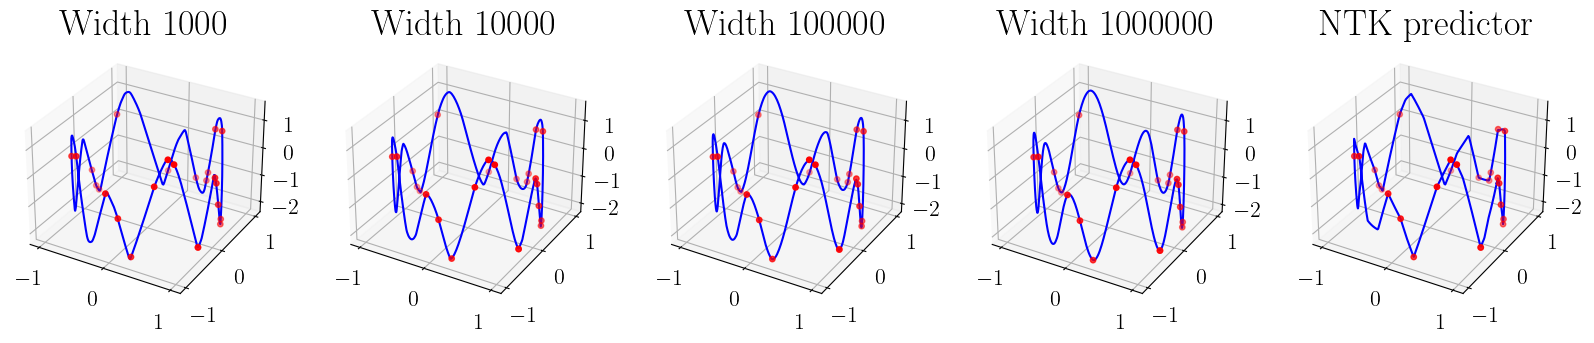

In [ ]:
#@title plot of all NN pred for different network width (Latex version)

##### Plot #####

# get all predictions_nn data
# sizes = [32, 128, 512, 2048]
sizes = [1000,10000,100000,1000000]
predictions_nn_list = []
for i in sizes:
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred"  + f"/NN_{int(i)}_10cos_pred", 'rb') as f:
    predictions_nn_list.append(pickle.load(f)[-1])
predictions_nn_list.append(predictions) # append NTK predictions

# Create a figure and explicitly add 3D subplots
# fig = plt.figure(figsize=set_size(380.69788))
fig = plt.figure(figsize=(20, 20))
# Add each 3D subplot
N_subplots = len(sizes)+1 # +1 for ntk plot
axs = []
for i in range(N_subplots):
    # Calculate the correct subplot index
    axs.append(fig.add_subplot(1, N_subplots, i+1, projection='3d'))

# plot
for i in range(N_subplots):
  predictions_nn = predictions_nn_list[i]
  axs[i].plot(grid.numpy()[:,0], grid.numpy()[:,1], predictions_nn, color = "blue", zorder=1)
  axs[i].scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train, color = "red", zorder=2, s = 15)
  # axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "red", zorder=1, alpha = 0.5)


# set titles
for i in range(len(sizes)):
  axs[i].set_title(f"Width {sizes[i]}", fontsize=26)
# axs[0].set_title(f"Ground truth")
axs[-1].set_title(f"NTK predictor", fontsize=26)
# increase tick number size
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=16)
# plt.tight_layout()
plt.savefig("cosdata-adam-1layer.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
#@title plot of all NN pred - NTK for different network width (Latex version)

##### Plot #####

# get all predictions_nn data
# sizes = [32, 128, 512, 2048]
sizes = [1000,10000,100000,1000000]
predictions_nn_list = []
for i in sizes:
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(i)}_10cos_pred", 'rb') as f:
    predictions_nn_list.append(pickle.load(f)[-1])
# predictions_nn_list.append(predictions) # append NTK predictions

# Create a figure and explicitly add 3D subplots
# fig = plt.figure(figsize=set_size(380.69788))
fig = plt.figure(figsize=(20, 20))
# Add each 3D subplot
N_subplots = len(sizes) # +1 for ntk plot
axs = []
for i in range(N_subplots):
    # Calculate the correct subplot index
    axs.append(fig.add_subplot(1, N_subplots, i+1, projection='3d'))

# plot
for i in range(N_subplots):
  predictions_nn = predictions_nn_list[i]
  axs[i].plot(grid.numpy()[:,0], grid.numpy()[:,1], np.abs(predictions_nn.numpy() - predictions), color = "blue", zorder=1)
  # axs[i].scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train, color = "red", zorder=2, s = 15)
  # axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "red", zorder=1, alpha = 0.5)


# set titles
for i in range(len(sizes)):
  axs[i].set_title(f"Width {sizes[i]}", fontsize=26)
# axs[0].set_title(f"Ground truth")
# axs[-1].set_title(f"NTK predictor", fontsize=26)
# increase tick number size
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=16)

# plt.tight_layout()
plt.savefig("cosdata-adam-1layer-error.pdf", format='pdf', bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/MACHINELEARNING/Project/NTK/Experiments/supNorm_ntkpred_and_fnnpred/NN_1000_10cos_pred'

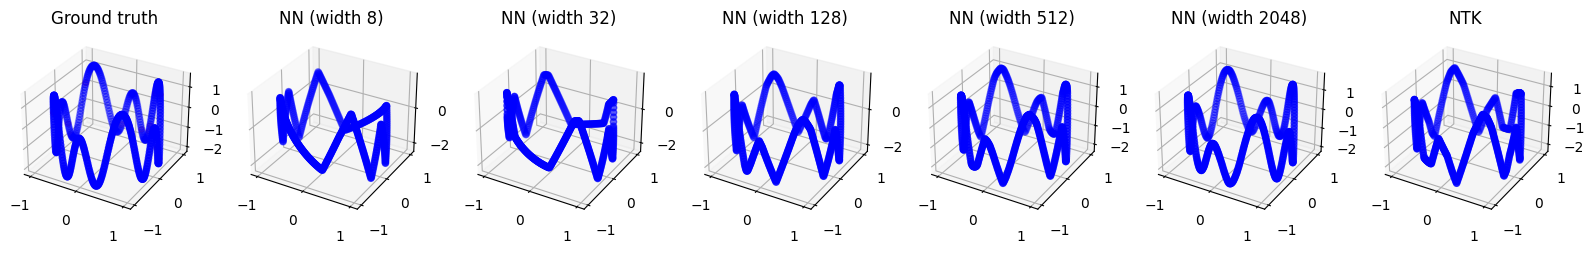

In [ ]:
#@title plot of all NN pred for different network width (Adapted version)

##### Plot #####
# Create a figure and explicitly add 3D subplots
fig = plt.figure(figsize=(20, 20))
# Add each 3D subplot
N_subplots = 5+1+1
axs = []
for i in range(N_subplots):
    # Calculate the correct subplot index
    axs.append(fig.add_subplot(1, N_subplots, i+1, projection='3d'))

# get all predictions_nn data
sizes = [2**3, 2**5, 2**7, 2**9, 2**11]
predictions_nn_list = [Y_grid]
for i in sizes:
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(i)}_10cos_pred", 'rb') as f:
    predictions_nn_list.append(pickle.load(f)[-1])
predictions_nn_list.append(predictions) # append NTK predictions

# plot
for i in range(N_subplots):
  predictions_nn = predictions_nn_list[i]
  axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions_nn, color = "blue", zorder=1)
  # axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "red", zorder=1, alpha = 0.5)
axs[0].scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train, color = "red", zorder=2, s = 15)

# set titles
for i in range(1, N_subplots-1):
  axs[i].set_title(f"NN (width {sizes[i-1]})")
axs[0].set_title(f"Ground truth")
axs[-1].set_title(f"NTK")
# plt.tight_layout()
# plt.savefig("ntkVSnn.jpeg")
plt.show()

In [ ]:
sizes = [32,128,512,2048]
for size in sizes:
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{size}_10cos_loss", 'rb') as f:
    losses = pickle.load(f)
  print(losses[-1], size)
  plt.loglog(losses, color = "blue")
  plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/MACHINELEARNING/Project/NTK/Experiments/supNorm_ntkpred_and_fnnpred/NN_32_10cos_loss'

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/MACHINELEARNING/Project/NTK/Experiments/supNorm_ntkpred_and_fnnpred/NN_1024_10cos_pred'

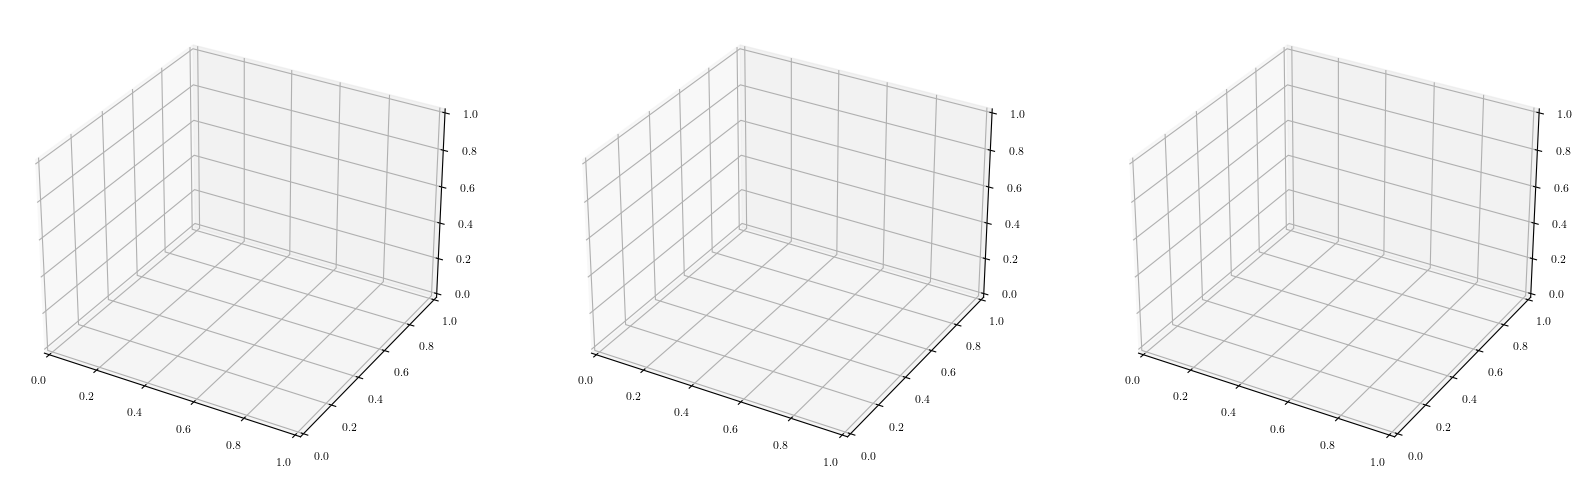

In [ ]:
#@title plot of all NN pred for different network width (Adapted version)

##### Plot #####
# Create a figure and explicitly add 3D subplots
fig = plt.figure(figsize=(20, 20))
# Add each 3D subplot
N_subplots = 1+1+1
axs = []
for i in range(N_subplots):
    # Calculate the correct subplot index
    axs.append(fig.add_subplot(1, N_subplots, i+1, projection='3d'))

# get all predictions_nn data
# sizes = [int(2**i) for i in range(9,11,1)]
sizes = [int(2**10)]
predictions_nn_list = [Y_grid]
for i in sizes:
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{int(i)}_10cos_pred", 'rb') as f:
    predictions_nn_list.append(pickle.load(f)[-1])
predictions_nn_list.append(predictions) # append NTK predictions

# plot
for i in range(N_subplots):
  predictions_nn = predictions_nn_list[i]
  axs[i].plot(grid.numpy()[:,0], grid.numpy()[:,1], predictions_nn, color = "blue", zorder=1)
  # axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "red", zorder=1, alpha = 0.5)
axs[0].scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train, color = "red", zorder=2, s = 15)

# set titles
for i in range(1, N_subplots-1):
  axs[i].set_title(f"NN (width {sizes[i-1]})")
axs[0].set_title(f"Ground truth")
axs[-1].set_title(f"NTK")

# plt.tight_layout()
# plt.savefig("ntkVSnn.jpeg")
plt.show()

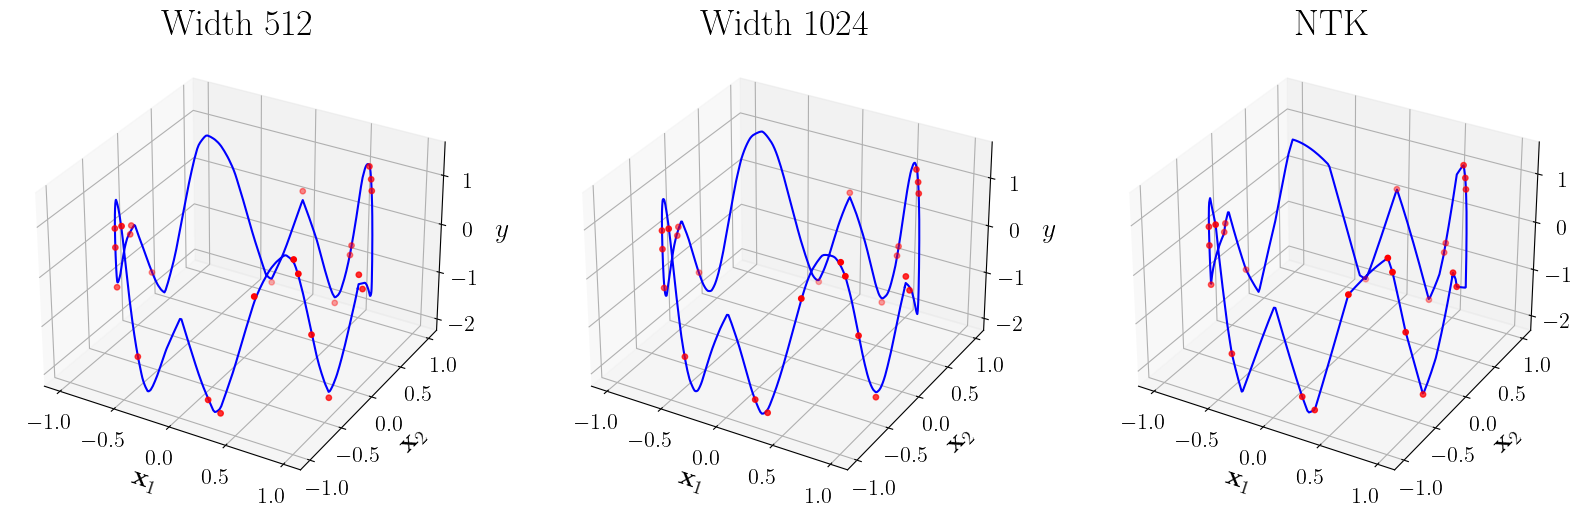

In [ ]:
#@title plot of all NN pred for different network width (Latex version)

##### Plot #####

# get all predictions_nn data
sizes = [512, 1024]
# sizes = [int(2**10)]
predictions_nn_list = []
for i in sizes:
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/EPOCHS:120_000_000-run0" + f"/NN_{int(i)}_10cos_pred", 'rb') as f:
    predictions_nn_list.append(pickle.load(f)[-1])
predictions_nn_list.append(predictions) # append NTK predictions

# Create a figure and explicitly add 3D subplots
# fig = plt.figure(figsize=set_size(380.69788))
fig = plt.figure(figsize=(20, 20))
# Add each 3D subplot
N_subplots = len(sizes) + 1
axs = []
for i in range(N_subplots):
    # Calculate the correct subplot index
    axs.append(fig.add_subplot(1, N_subplots, i+1, projection='3d'))

# plot
for i in range(N_subplots):
  predictions_nn = predictions_nn_list[i]
  axs[i].plot(grid.numpy()[:,0], grid.numpy()[:,1], predictions_nn, color = "blue", zorder=1)
  # axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "red", zorder=1, alpha = 0.5)
  axs[i].scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train, color = "red", zorder=2, s = 15)

# set titles
for i in range(len(sizes)):
  axs[i].set_title(f"Width {sizes[i]}", fontsize=26)
# axs[0].set_title(f"Ground truth")
axs[-1].set_title(f"NTK", fontsize=26)

# increase tick number size and labels
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(r'$\mathbf{x}_1$', fontsize=20)
    ax.set_ylabel(r'$\mathbf{x}_2$', fontsize=20)
    ax.set_zlabel(r'$y$', fontsize=20)
    ax.zaxis.labelpad = 6
    ax.xaxis.labelpad = 6
    ax.yaxis.labelpad = 6
# plt.tight_layout()
plt.savefig("120_000_000EPOCHS.pdf", format='pdf', bbox_inches='tight')
plt.show()

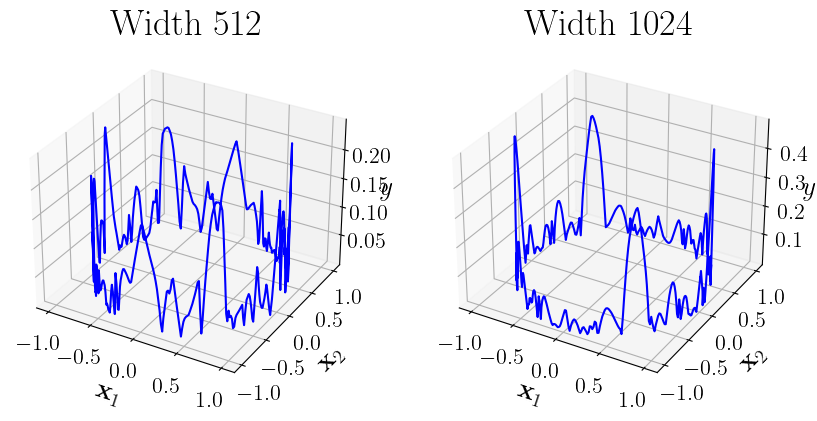

In [ ]:
#@title plot of all NN pred - ntk for different network width (Latex version)

##### Plot #####

# get all predictions_nn data
sizes = [512, 1024]
# sizes = [int(2**10)]
predictions_nn_list = []
for i in sizes:
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/EPOCHS:120_000_000-run0" + f"/NN_{int(i)}_10cos_pred", 'rb') as f:
    predictions_nn_list.append(pickle.load(f)[-1])
# predictions_nn_list.append(predictions) # append NTK predictions

# Create a figure and explicitly add 3D subplots
# fig = plt.figure(figsize=set_size(380.69788))
fig = plt.figure(figsize=(10, 10))
# Add each 3D subplot
N_subplots = len(sizes)
axs = []
for i in range(N_subplots):
    # Calculate the correct subplot index
    axs.append(fig.add_subplot(1, N_subplots, i+1, projection='3d'))

# plot
for i in range(N_subplots):
  predictions_nn = predictions_nn_list[i]
  axs[i].plot(grid.numpy()[:,0], grid.numpy()[:,1], np.abs(predictions_nn.numpy() - predictions), color = "blue", zorder=1)
  # axs[i].scatter(grid.numpy()[:,0], grid.numpy()[:,1], predictions, color = "red", zorder=1, alpha = 0.5)
  # axs[i].scatter(X_train.numpy()[:,0], X_train.numpy()[:,1], Y_train, color = "red", zorder=2, s = 15)

# set titles
for i in range(len(sizes)):
  axs[i].set_title(f"Width {sizes[i]}", fontsize=26)
# axs[0].set_title(f"Ground truth")
# axs[-1].set_title(f"NTK", fontsize=26)

# increase tick number size and labels
for ax in axs:
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(r'$\mathbf{x}_1$', fontsize=20)
    ax.set_ylabel(r'$\mathbf{x}_2$', fontsize=20)
    ax.set_zlabel(r'$y$', fontsize=20)
    ax.zaxis.labelpad = -2
    ax.xaxis.labelpad = 6
    ax.yaxis.labelpad = 6
# plt.tight_layout()
plt.savefig("120_000_000EPOCHS-error.pdf", format='pdf', bbox_inches='tight')
plt.show()

0.002239544875919819 1000


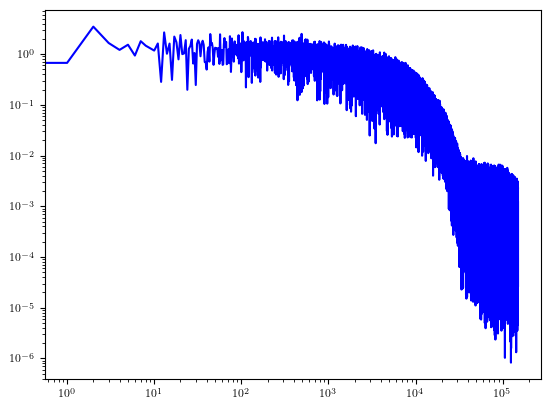

4.5660814066650346e-05 10000


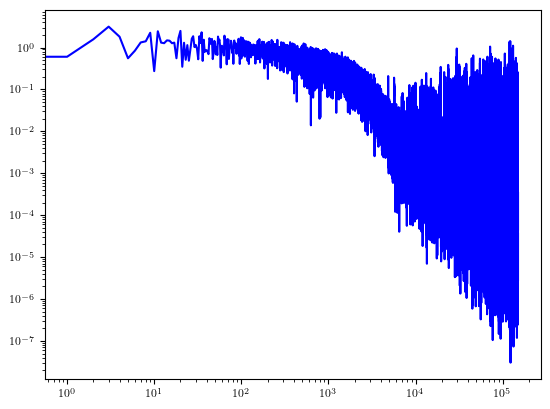

0.0009215138852596283 100000


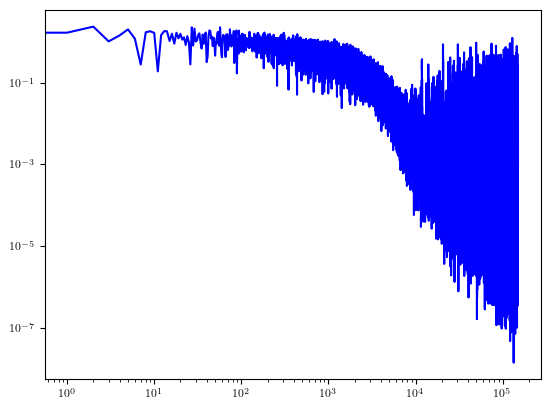

1.0427257620904129e-05 1000000


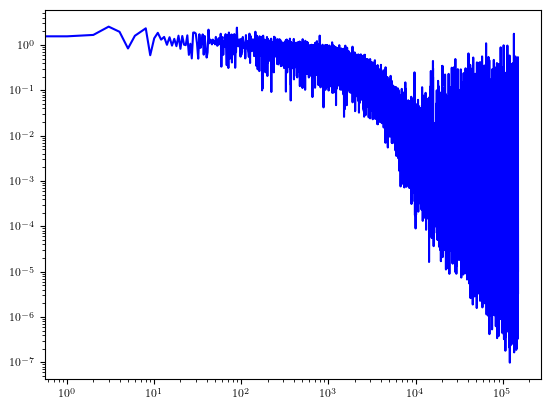

In [ ]:
# sizes = [int(2**i) for i in range(9,11,1)]
sizes = [1000,10000,100000,1000000]
for size in sizes:
  with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{size}_10cos_loss", 'rb') as f:
    losses = pickle.load(f)
  print(losses[-1], size)
  plt.loglog(losses, color = "blue")
  plt.show()

In [ ]:
# sizes = [int(2**i) for i in range(9,11,1)]
size = int(2**10)
# sizes = [1000,10000,100000,1000000]
with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/NN_{size}_10cos_loss", 'rb') as f:
  losses1 = pickle.load(f)
with open(folder_path + f"/supNorm_ntkpred_and_fnnpred" + f"/EPOCHS:24_000_000-twolayers" + f"/NN_{size}_10cos_loss", 'rb') as f:
  losses0 = pickle.load(f)

print(losses1[-1], size)
plt.loglog(losses0 + losses1 , color = "blue")
plt.show()

NameError: name 'size' is not defined